In [ ]:
# Simple Chess Player Types Analysis
# For "Game-based quantification of chess player types" Master Thesis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --------------------------------------------------
# 1. LOAD DATA AND TRANSFORM TO PLAYER-CENTRIC FORMAT
# --------------------------------------------------

# Load the dataset
file_path = '../data/processed/4players_example_features.csv'
chess_df = pd.read_csv(file_path)

print(f"Original dataset shape: {chess_df.shape}")

# Define known player types from the book
activist_players = [
    "Tal, Mihail"
]

theorist_players = [
    "Botvinnik, Mikhail"
]

reflector_players = [
    "Capablanca, Jose Raul"
]

pragmatist_players = [
    "Fischer, Robert James"
]

# Create a dictionary mapping player names to their types
player_type_map = {}
for player in activist_players:
    player_type_map[player] = "Activist"
for player in theorist_players:
    player_type_map[player] = "Theorist"  
for player in reflector_players:
    player_type_map[player] = "Reflector"
for player in pragmatist_players:
    player_type_map[player] = "Pragmatist"

# Identify categorical, identifier, and numerical features
categorical_cols = ['event', 'site', 'date', 'round', 'white', 'black', 'result',
                   'white_title', 'black_title', 'eco', 'opening', 'result_category', 
                   'eco_family', 'opening_name']
identifier_cols = ['white_elo', 'black_elo', 'year']

# Get all columns, then remove categorical and identifier columns to get numerical features
all_cols = chess_df.columns.tolist()
numerical_features = [col for col in all_cols if col not in categorical_cols and col not in identifier_cols]

# Create a dataframe with just the numerical features for analysis
numerical_df = chess_df[numerical_features].copy()

# Handle missing values in numerical features - impute with median
imputer = SimpleImputer(strategy='median')
numerical_df_imputed = pd.DataFrame(imputer.fit_transform(numerical_df), columns=numerical_df.columns)

# Split features into white-specific, black-specific, and common
white_features = [col for col in numerical_features if col.startswith('white_')]
black_features = [col for col in numerical_features if col.startswith('black_')]
common_features = [col for col in numerical_features if not col.startswith('white_') and not col.startswith('black_')]

print(f"\nFeature distribution:")
print(f"White player features: {len(white_features)}")
print(f"Black player features: {len(black_features)}")
print(f"Common game features: {len(common_features)}")

# --------------------------------------------------
# 2. CREATE PLAYER-CENTRIC DATAFRAME
# --------------------------------------------------

# Define phase-specific features where 0 means "phase not played"
phase_specific_features = [
    'white_opening_accuracy', 'white_middlegame_accuracy', 'white_endgame_accuracy',
    'black_opening_accuracy', 'black_middlegame_accuracy', 'black_endgame_accuracy'
]

# Create two new dataframes for players
players_data = []

# Process white players
for i, row in chess_df.iterrows():
    player_data = {}
    
    # Add player info
    player_data['player_name'] = row['white'] if 'white' in chess_df.columns else f"White_Player_{i}"
    player_data['player_color'] = 'white'
    player_data['opponent_name'] = row['black'] if 'black' in chess_df.columns else f"Black_Player_{i}"
    player_data['player_elo'] = row['white_elo'] if 'white_elo' in chess_df.columns else None
    
    # Add player type if known
    if 'white' in chess_df.columns and row['white'] in player_type_map:
        player_data['player_type'] = player_type_map[row['white']]
    else:
        player_data['player_type'] = None
    
    # Add game identifiers
    player_data['game_id'] = i
    if 'result' in chess_df.columns:
        player_data['result'] = row['result']
    
    # Add player-specific features (removing the prefix)
    for feature in white_features:
        feature_name = feature.replace('white_', '')
        value = numerical_df_imputed.iloc[i][feature]
        
        # Handle phase-specific features where 0 means "phase not played"
        if feature in phase_specific_features and value == 0:
            player_data[feature_name] = np.nan  # Mark as missing rather than 0
        else:
            player_data[feature_name] = value
    
    # Add common features
    for feature in common_features:
        player_data[feature] = numerical_df_imputed.iloc[i][feature]
    
    players_data.append(player_data)

# Process black players
for i, row in chess_df.iterrows():
    player_data = {}
    
    # Add player info
    player_data['player_name'] = row['black'] if 'black' in chess_df.columns else f"Black_Player_{i}"
    player_data['player_color'] = 'black'
    player_data['opponent_name'] = row['white'] if 'white' in chess_df.columns else f"White_Player_{i}"
    player_data['player_elo'] = row['black_elo'] if 'black_elo' in chess_df.columns else None
    
    # Add player type if known
    if 'black' in chess_df.columns and row['black'] in player_type_map:
        player_data['player_type'] = player_type_map[row['black']]
    else:
        player_data['player_type'] = None
    
    # Add game identifiers
    player_data['game_id'] = i
    if 'result' in chess_df.columns:
        player_data['result'] = row['result']
    
    # Add player-specific features (removing the prefix)
    for feature in black_features:
        feature_name = feature.replace('black_', '')
        value = numerical_df_imputed.iloc[i][feature]
        
        # Handle phase-specific features where 0 means "phase not played"
        if feature in phase_specific_features and value == 0:
            player_data[feature_name] = np.nan  # Mark as missing rather than 0
        else:
            player_data[feature_name] = value
    
    # Add common features
    for feature in common_features:
        player_data[feature] = numerical_df_imputed.iloc[i][feature]
    
    players_data.append(player_data)

# Convert to dataframe
players_df = pd.DataFrame(players_data)

print(f"\nPlayer-centric dataset shape: {players_df.shape}")
print(f"This represents {chess_df.shape[0]} games × 2 players = {chess_df.shape[0]*2} player instances")

# Count players with known types
known_types_count = players_df['player_type'].notna().sum()
print(f"\nPlayers with known types in dataset: {known_types_count} ({known_types_count/len(players_df)*100:.2f}%)")

# Count by type
if known_types_count > 0:
    type_counts = players_df['player_type'].value_counts()
    print("\nDistribution of known player types:")
    print(type_counts)

# drop forced_complexity_index,speculative_sacrifice_ratio,material_imbalance_tolerance
# columns_to_drop = ['forced_complexity_index', 'speculative_sacrifice_ratio', 'material_imbalance_tolerance']
# columns_to_drop = [col for col in columns_to_drop if col in players_df.columns]
# if columns_to_drop:
#     players_df = players_df.drop(columns=columns_to_drop)
#     print(f"Dropped columns: {columns_to_drop}")
# else:
#     print("Columns to drop not found in DataFrame.")

# Save the player-centric dataframe for future use
players_df.to_csv('4players_centric_data.csv', index=False)
print("\nSaved player-centric data to '4players_centric_data.csv'")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# --------------------------------------------------
# 1. LOAD DATA AND PREPARE FOR ANALYSIS
# --------------------------------------------------

# Load the player-centric data
players_df = pd.read_csv('4players_centric_data.csv')

# Print basic information about the dataset
print(f"Dataset shape: {players_df.shape}")
print("\nPlayer types in dataset:")
print(players_df['player_type'].value_counts(dropna=False))

# Identify players with known types
known_players = players_df[players_df['player_type'].notna()]['player_name'].unique()
print("\nPlayers with known types:")
for player in known_players:
    player_type = players_df[players_df['player_name'] == player]['player_type'].iloc[0]
    print(f"- {player}: {player_type}")

# Get counts of games per player
print("\nGames per player:")
player_counts = players_df['player_name'].value_counts()
for player in known_players:
    print(f"- {player}: {player_counts.get(player, 0)} instances")

# --------------------------------------------------
# 2. PREPARE DATA FOR PCA
# --------------------------------------------------

# Define columns to exclude from feature set (metadata)
metadata_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
                'player_type', 'game_id', 'result']

# Get feature columns
feature_cols = [col for col in players_df.columns if col not in metadata_cols]
print(f"\nNumber of features: {len(feature_cols)}")

# Filter only the players with known types
typed_players_df = players_df[players_df['player_type'].notna()].copy()

# Check for missing values and impute if necessary
missing_values = typed_players_df[feature_cols].isnull().sum()
print("\nFeatures with missing values:")
print(missing_values[missing_values > 0].sort_values(ascending=False).head())

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
typed_players_df[feature_cols] = imputer.fit_transform(typed_players_df[feature_cols])

# Extract features for PCA
X = typed_players_df[feature_cols].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------------
# 3. PCA ANALYSIS FOR ALL PLAYERS
# --------------------------------------------------

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['player_name'] = typed_players_df['player_name'].values
pca_df['player_type'] = typed_players_df['player_type'].values

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_ * 100
print("\nExplained variance ratio:")
print(f"PC1: {explained_variance[0]:.2f}%")
print(f"PC2: {explained_variance[1]:.2f}%")
print(f"Total: {sum(explained_variance):.2f}%")

# Create a scatter plot of all players
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='player_type', 
                          style='player_name', s=100, alpha=0.8)
plt.title('PCA of Chess Players by Type', fontsize=16)
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}%)', fontsize=14)
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}%)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig('all_players_pca.png', dpi=300)
plt.show()

# --------------------------------------------------
# 4. PAIRWISE PLAYER COMPARISON
# --------------------------------------------------

# If we have at least 2 players with known types, do pairwise comparison
if len(known_players) >= 2:
    # Get all possible player pairs
    from itertools import combinations
    player_pairs = list(combinations(known_players, 2))
    
    # Create a 2x2 grid of subplots for the first 4 pairs
    num_pairs = min(len(player_pairs), 4)
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    
    # For each pair, create a PCA plot
    for i, (player1, player2) in enumerate(player_pairs[:num_pairs]):
        # Filter data for just these two players
        pair_df = typed_players_df[typed_players_df['player_name'].isin([player1, player2])].copy()
        
        # Extract features and standardize
        X_pair = pair_df[feature_cols].values
        X_pair_scaled = StandardScaler().fit_transform(X_pair)
        
        # Apply PCA
        pca_pair = PCA(n_components=2)
        X_pair_pca = pca_pair.fit_transform(X_pair_scaled)
        
        # Create a DataFrame for plotting
        pair_pca_df = pd.DataFrame(data=X_pair_pca, columns=['PC1', 'PC2'])
        pair_pca_df['player_name'] = pair_df['player_name'].values
        pair_pca_df['player_type'] = pair_df['player_type'].values
        
        # Calculate explained variance
        pair_explained_var = pca_pair.explained_variance_ratio_ * 100
        
        # Create scatter plot
        ax = axes[i]
        sns.scatterplot(data=pair_pca_df, x='PC1', y='PC2', 
                         hue='player_name', style='player_type', s=100, alpha=0.8, ax=ax)
        
        # Set plot titles and labels
        ax.set_title(f'{player1} vs {player2}', fontsize=14)
        ax.set_xlabel(f'PC1 ({pair_explained_var[0]:.2f}%)', fontsize=12)
        ax.set_ylabel(f'PC2 ({pair_explained_var[1]:.2f}%)', fontsize=12)
        ax.legend(loc='upper right', fontsize=10)
        
        # Add a text about separation
        separation = np.mean(np.abs(pair_pca_df.groupby('player_name')['PC1'].mean().diff()))
        ax.text(0.05, 0.05, f'Mean PC1 separation: {separation:.2f}', 
                transform=ax.transAxes, fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('pairwise_player_comparison.png', dpi=300)
    plt.show()

# --------------------------------------------------
# 5. FEATURE IMPORTANCE ANALYSIS
# --------------------------------------------------

# Calculate feature importance based on PCA loadings
loadings = pca.components_.T
feature_importance = np.abs(loadings[:, 0])  # Use absolute values of PC1 loadings
indices = np.argsort(feature_importance)[::-1]  # Sort in descending order

# Plot top 15 most important features
plt.figure(figsize=(14, 8))
plt.bar(range(15), feature_importance[indices[:15]])
plt.xticks(range(15), [feature_cols[i] for i in indices[:15]], rotation=45, ha='right')
plt.title('Top 15 Features Contributing to PC1', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

# --------------------------------------------------
# 6. IDENTIFY MOST DISTINGUISHING FEATURES
# --------------------------------------------------

# For the best pair (with highest separation), identify features that best distinguish them
if len(player_pairs) > 0:
    # Calculate separation score for each pair
    separation_scores = []
    
    for player1, player2 in player_pairs:
        pair_df = typed_players_df[typed_players_df['player_name'].isin([player1, player2])].copy()
        X_pair = pair_df[feature_cols].values
        X_pair_scaled = StandardScaler().fit_transform(X_pair)
        pca_pair = PCA(n_components=2)
        X_pair_pca = pca_pair.fit_transform(X_pair_scaled)
        
        # Calculate mean PC1 positions for each player
        pair_pca_df = pd.DataFrame(data=X_pair_pca, columns=['PC1', 'PC2'])
        pair_pca_df['player_name'] = pair_df['player_name'].values
        mean_pc1 = pair_pca_df.groupby('player_name')['PC1'].mean()
        separation = abs(mean_pc1.iloc[0] - mean_pc1.iloc[1])
        
        separation_scores.append((player1, player2, separation))
    
    # Sort pairs by separation score
    separation_scores.sort(key=lambda x: x[2], reverse=True)
    best_pair = separation_scores[0]
    print(f"\nBest separating pair: {best_pair[0]} vs {best_pair[1]} (separation: {best_pair[2]:.2f})")
    
    # Analyze feature differences for the best pair
    player1, player2 = best_pair[0], best_pair[1]
    pair_df = typed_players_df[typed_players_df['player_name'].isin([player1, player2])].copy()
    
    # Calculate mean feature values for each player
    player1_mean = pair_df[pair_df['player_name'] == player1][feature_cols].mean()
    player2_mean = pair_df[pair_df['player_name'] == player2][feature_cols].mean()
    
    # Calculate difference and sort
    diff = abs(player1_mean - player2_mean)
    diff_sorted = diff.sort_values(ascending=False)
    
    # Plot top 10 distinguishing features
    plt.figure(figsize=(14, 8))
    top_features = diff_sorted.index[:10]
    
    # Create a DataFrame for plotting
    compare_df = pd.DataFrame({
        'Feature': top_features,
        player1: player1_mean[top_features].values,
        player2: player2_mean[top_features].values
    })
    
    # Reshape for seaborn
    compare_df_melt = pd.melt(compare_df, id_vars=['Feature'], 
                              value_vars=[player1, player2],
                              var_name='Player', value_name='Value')
    
    # Plot
    sns.barplot(data=compare_df_melt, x='Feature', y='Value', hue='Player')
    plt.title(f'Top 10 Distinguishing Features: {player1} vs {player2}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('distinguishing_features.png', dpi=300)
    plt.show()
    
    # Print numerical differences
    print("\nTop 10 distinguishing features:")
    for feature in top_features:
        p1_val = player1_mean[feature]
        p2_val = player2_mean[feature]
        print(f"{feature}: {player1}={p1_val:.4f}, {player2}={p2_val:.4f}, diff={abs(p1_val-p2_val):.4f}")

# --------------------------------------------------
# 7. PAIRWISE SCATTER PLOTS OF ALL FEATURES
# --------------------------------------------------

# Create pairwise scatter plots of all features labeled with type of player
sns.pairplot(typed_players_df, hue='player_type', vars=feature_cols, plot_kws={'alpha': 0.5})
plt.suptitle('Pairwise Scatter Plots of All Features Labeled with Player Type', y=1.02, fontsize=16)
plt.savefig('pairwise_scatter_plots.png', dpi=300)
plt.show()

Original dataset shape: (9234, 47)

Player types in dataset:
player_type
NaN           4502
Activist      2437
Theorist       896
Pragmatist     816
Reflector      583
Name: count, dtype: int64

Balancing dataset by sampling 583 games from each player
Balanced dataset shape: (2332, 47)
player_name
Fischer, Robert James    583
Tal, Mihail              583
Botvinnik, Mikhail       583
Capablanca, Jose Raul    583
Name: count, dtype: int64

Number of features: 40

Top 15 discriminative features:
1. opening_length: 29.89
2. minor_piece_development: 27.99
3. top_move_alignment: 27.21
4. total_moves: 23.81
5. center_control_avg: 23.55
6. vulnerability_spikes: 17.85
7. endgame_length: 15.39
8. capture_frequency: 15.32
9. opening_novelty_score: 13.59
10. piece_exchange_rate: 13.27
11. top2_3_move_alignment: 13.09
12. queen_development: 12.82
13. pawn_exchange_rate: 11.11
14. piece_mobility_avg: 10.45
15. sharpness: 10.41


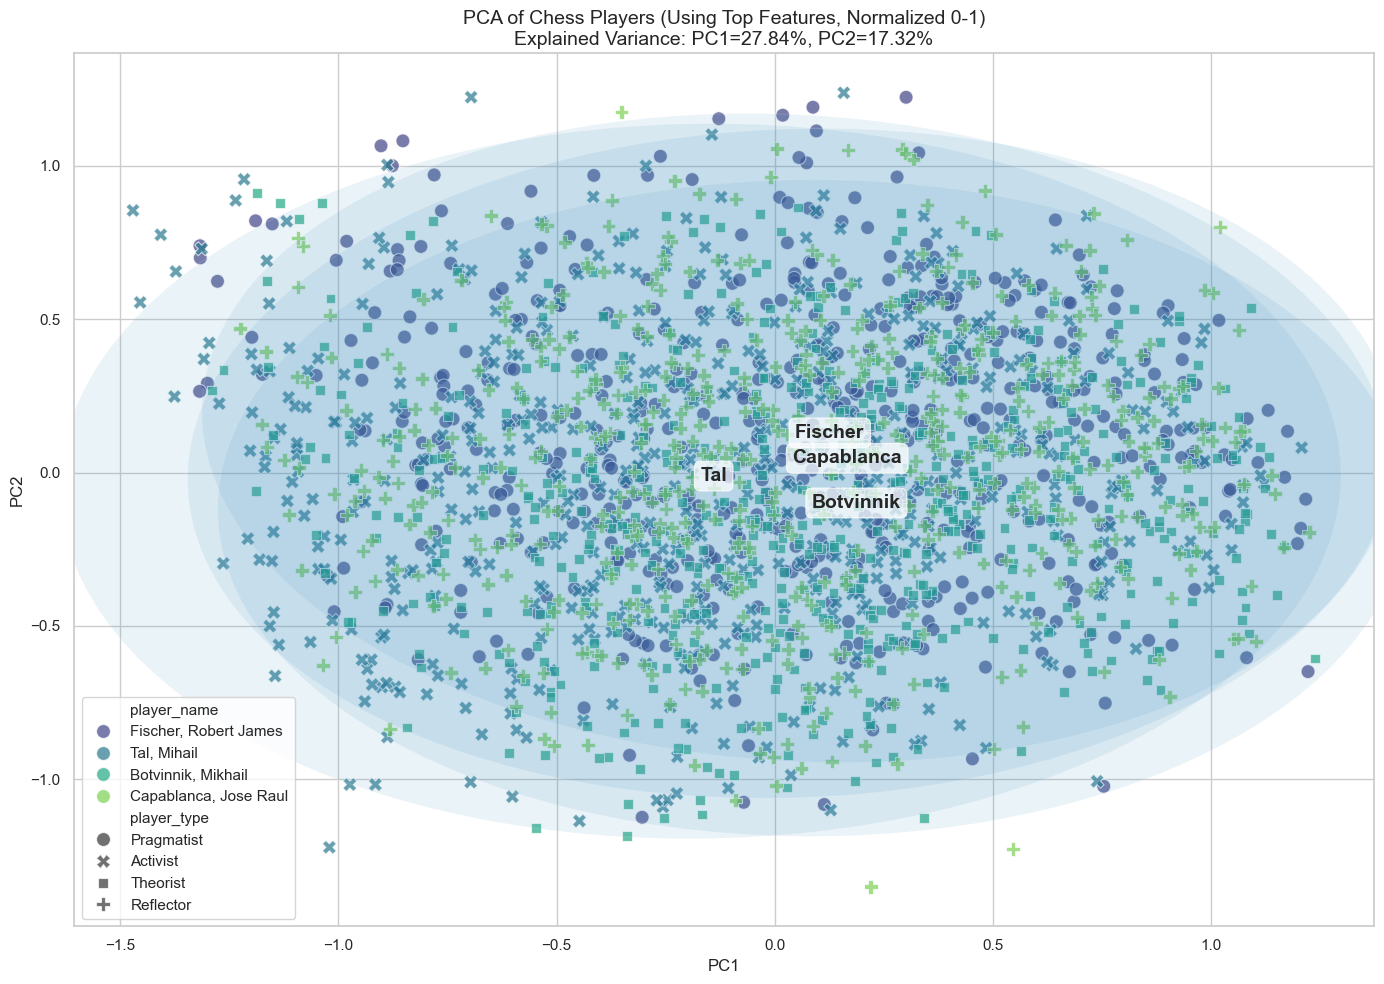


Separation metrics between player pairs:
Fischer, Robert James vs Tal, Mihail: Distance=0.26, Separation Score=0.51
Fischer, Robert James vs Botvinnik, Mikhail: Distance=0.23, Separation Score=0.48
Fischer, Robert James vs Capablanca, Jose Raul: Distance=0.08, Separation Score=0.17
Tal, Mihail vs Botvinnik, Mikhail: Distance=0.27, Separation Score=0.53
Tal, Mihail vs Capablanca, Jose Raul: Distance=0.22, Separation Score=0.43
Botvinnik, Mikhail vs Capablanca, Jose Raul: Distance=0.15, Separation Score=0.31

Best separated pair: Tal, Mihail vs Botvinnik, Mikhail (Score: 0.53)

Visualizing top feature pairs for all players


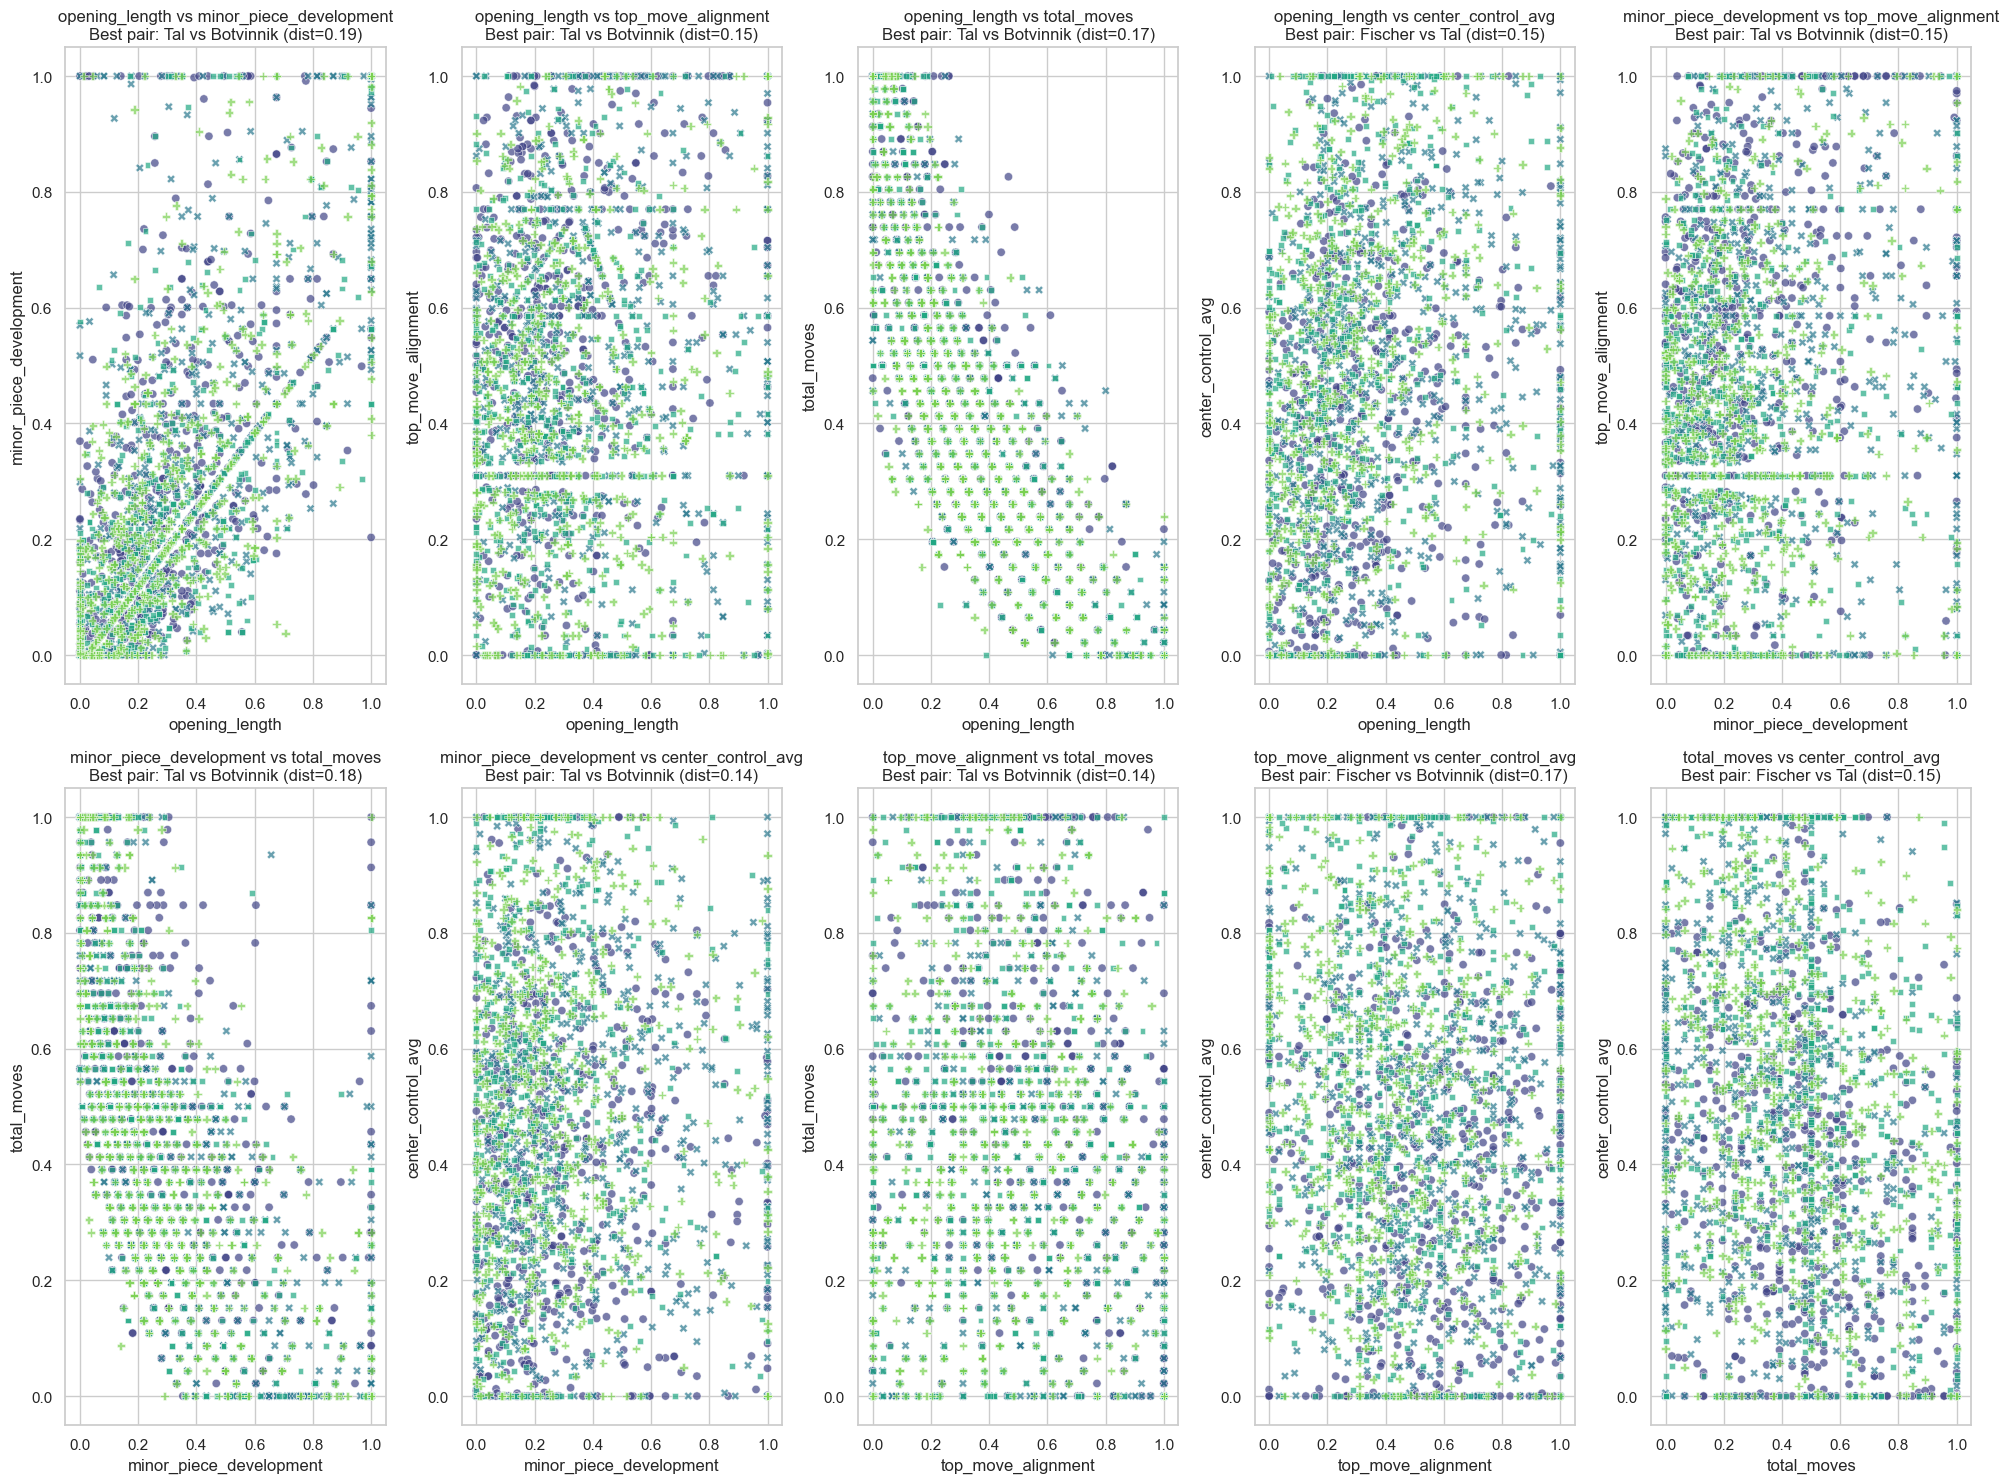


Top separating feature pairs for Tal vs Botvinnik:
opening_length vs minor_piece_development: Separation=0.69, Distance=0.19
minor_piece_development vs total_moves: Separation=0.66, Distance=0.18
opening_length vs total_moves: Separation=0.64, Distance=0.17
minor_piece_development vs sharpness: Separation=0.58, Distance=0.15
minor_piece_development vs top_move_alignment: Separation=0.57, Distance=0.15
minor_piece_development vs queen_development: Separation=0.57, Distance=0.15


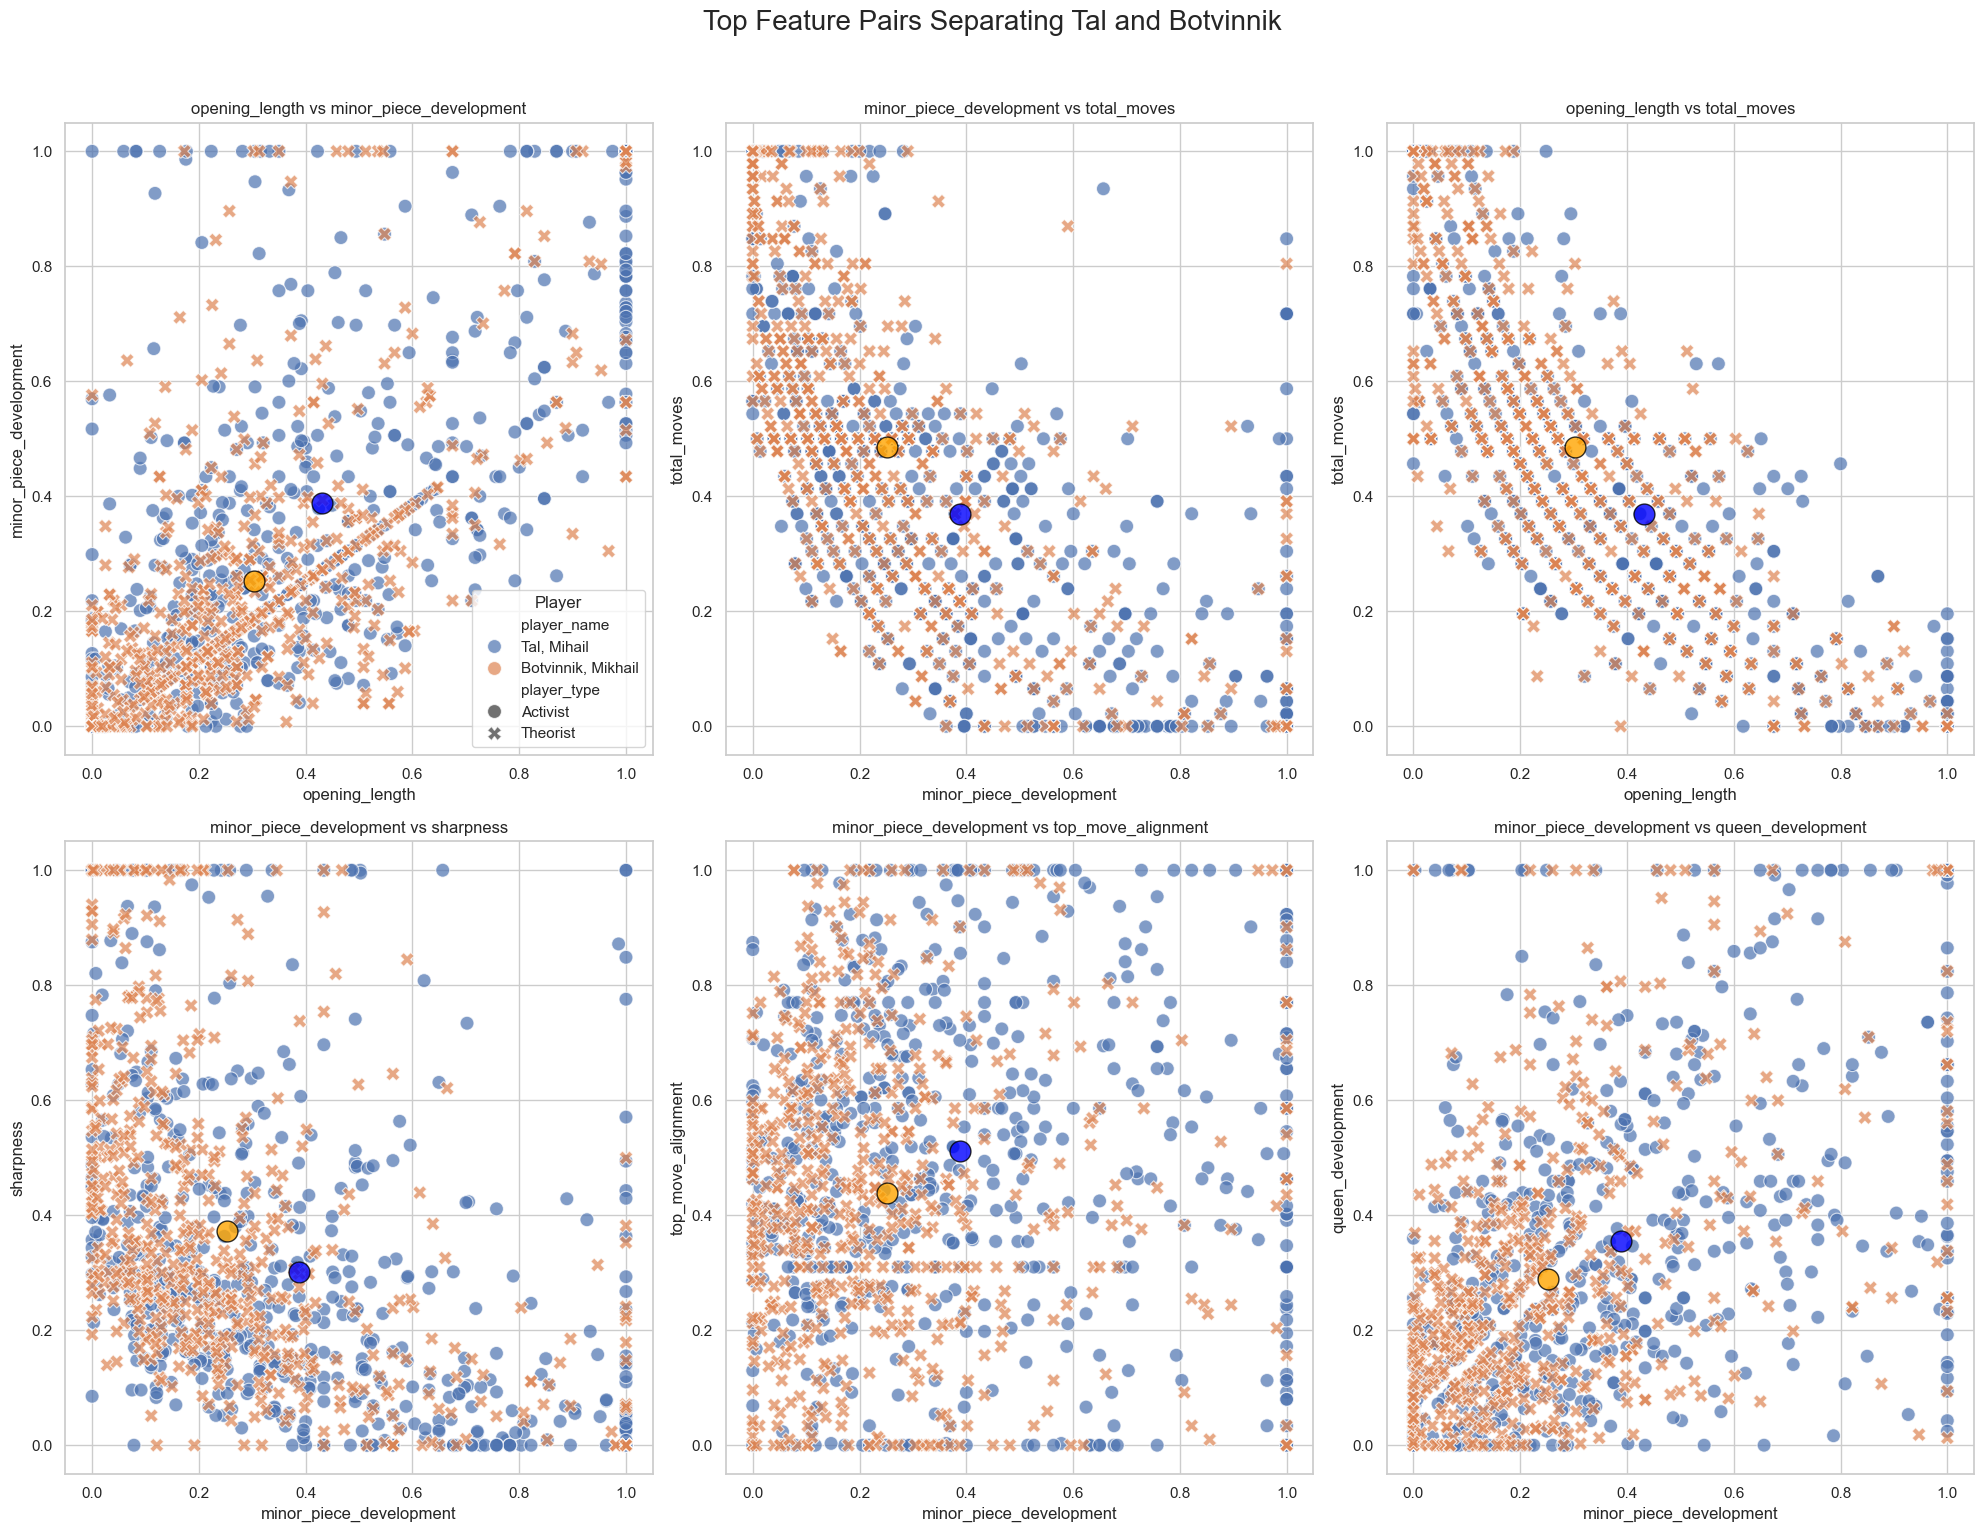

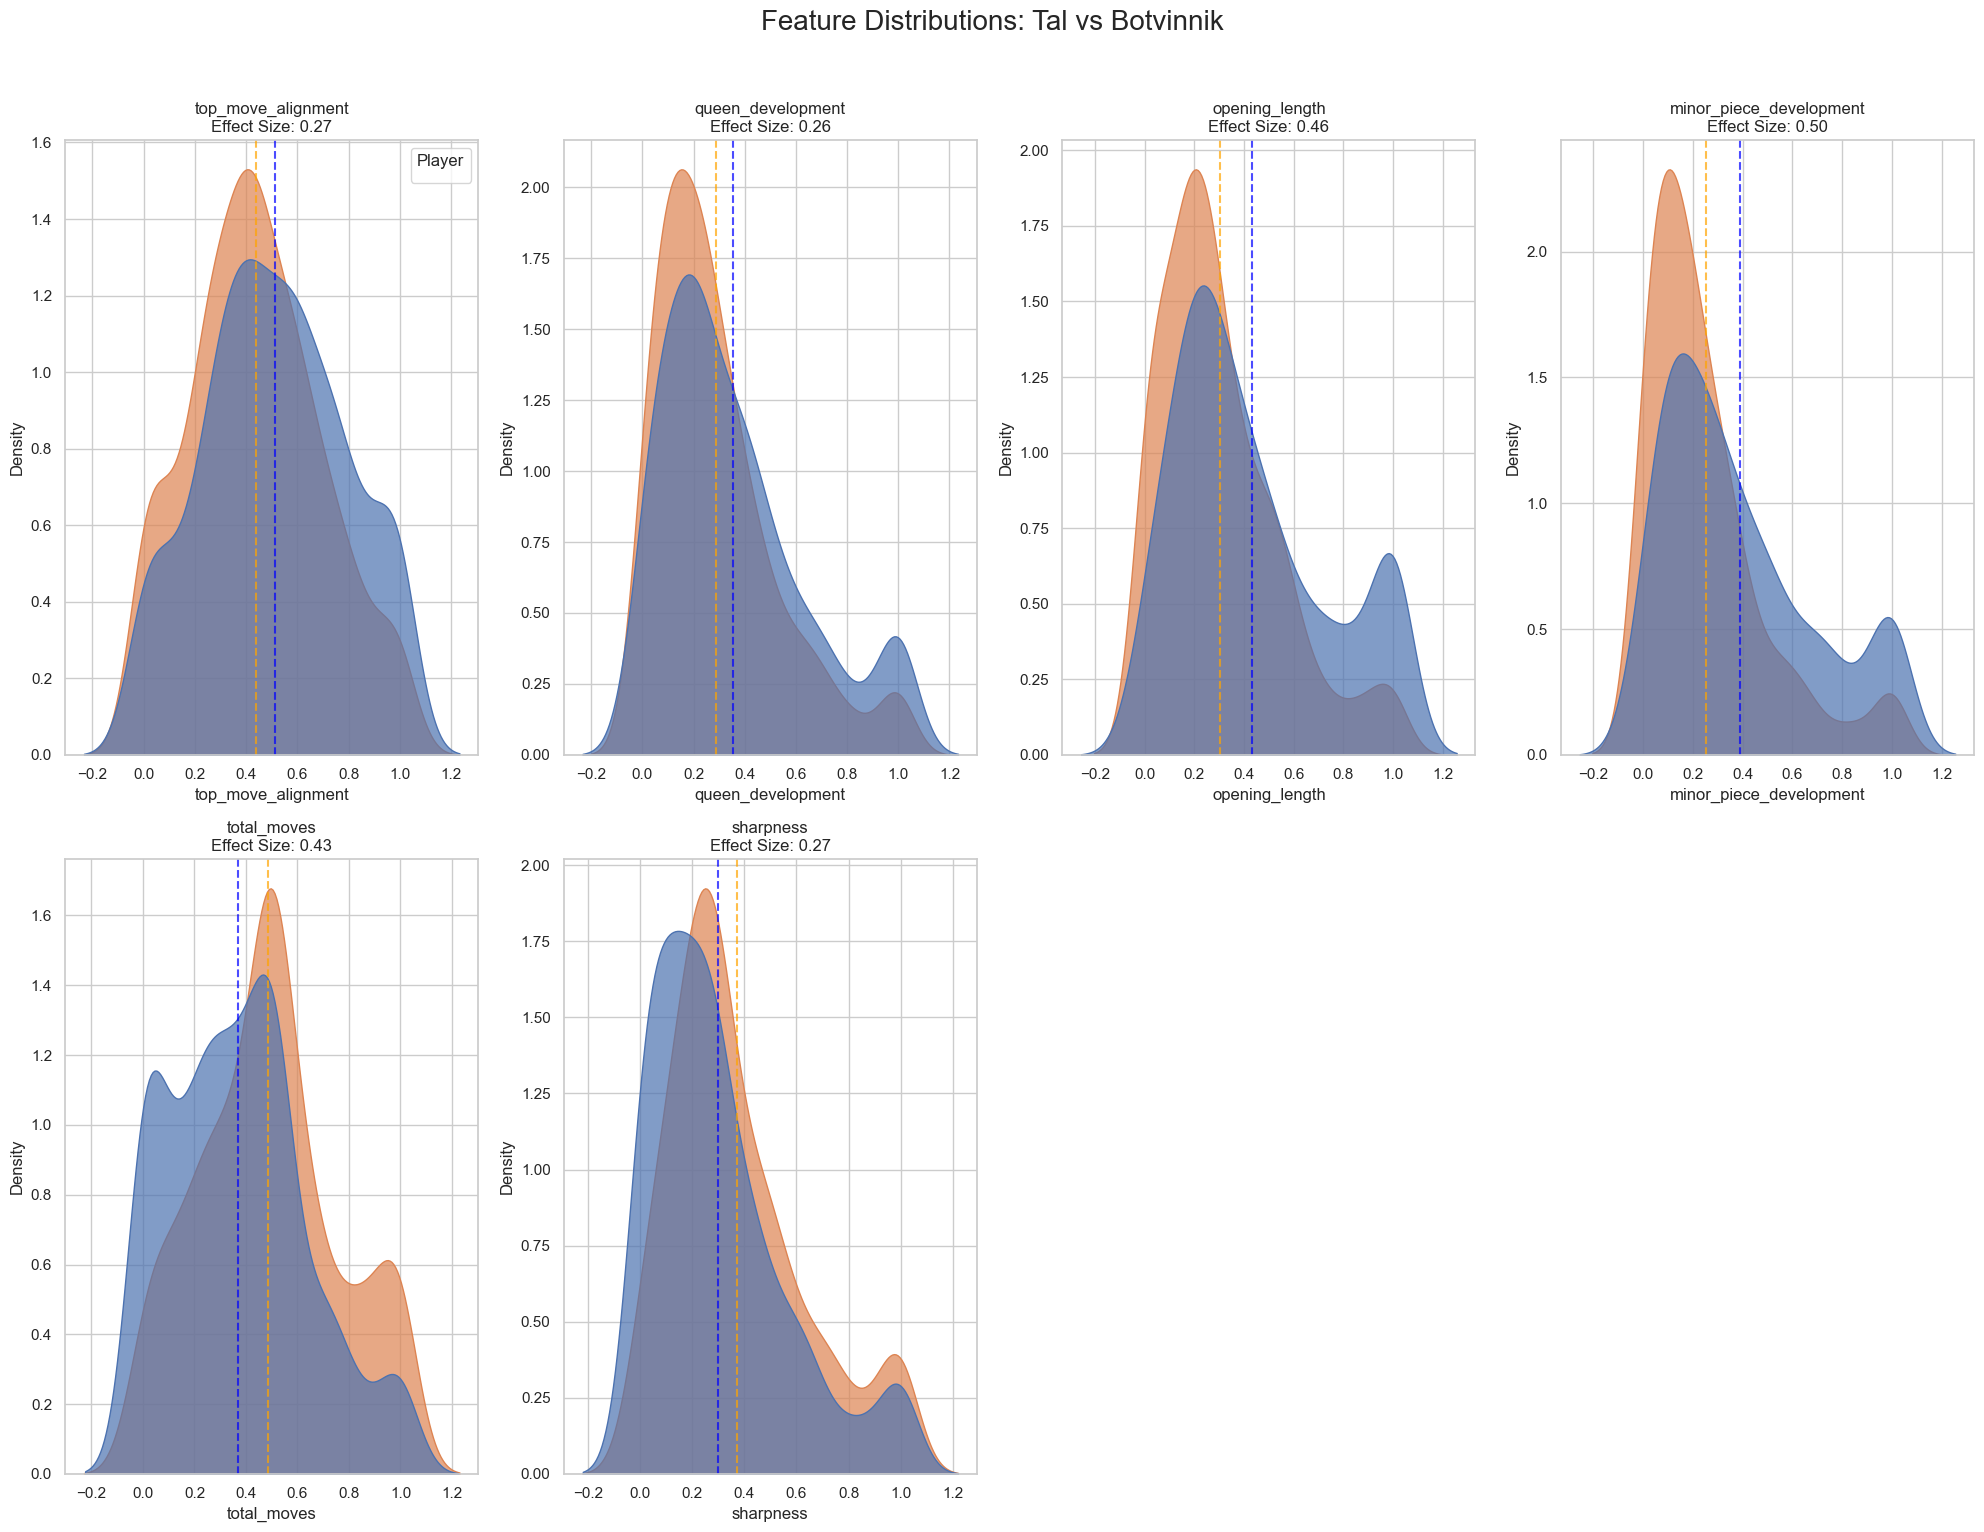

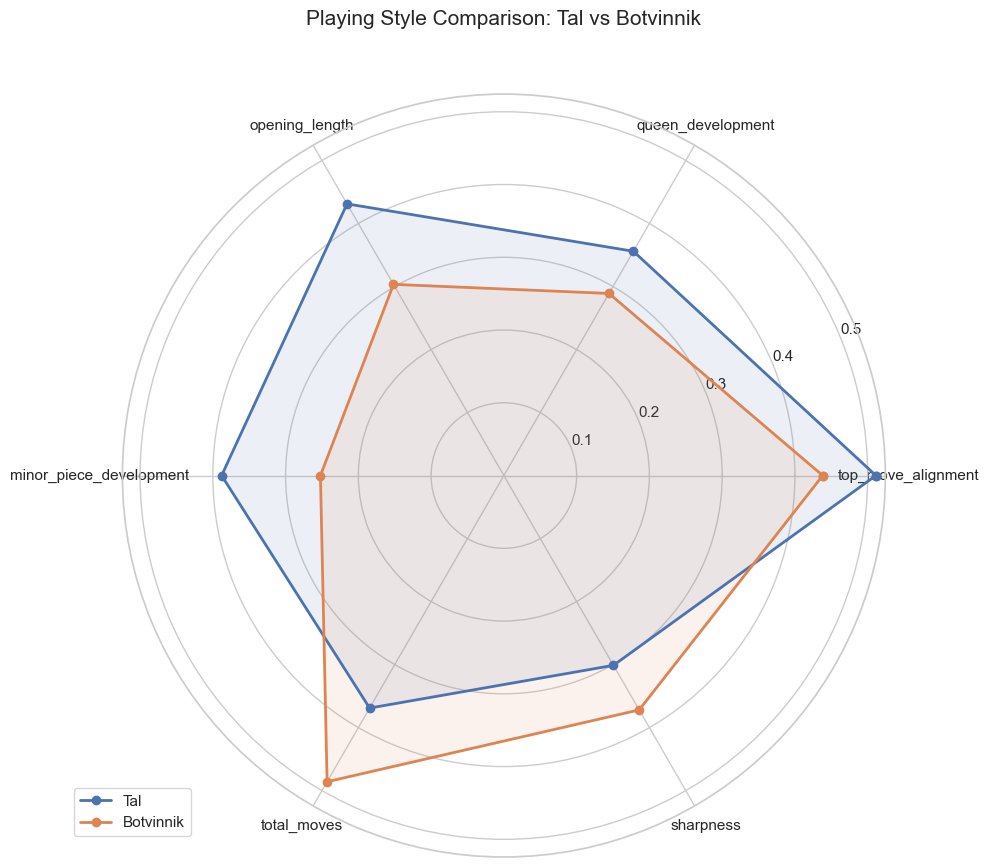


Player Style Profile Summary (Original Scale):
    Player       Type  opening_length  minor_piece_development  top_move_alignment  total_moves  center_control_avg  vulnerability_spikes  endgame_length  capture_frequency  opening_novelty_score  piece_exchange_rate  top2_3_move_alignment  queen_development  pawn_exchange_rate  piece_mobility_avg  sharpness
   Fischer Pragmatist        0.316156                 0.406678            0.587491    40.183533            1.026104              0.262423        0.247305           0.228275               0.448236             0.120894               0.269879           0.389904            0.107345           94.976180   2.737237
       Tal   Activist        0.374959                 0.464303            0.572980    34.975986            1.098796              0.247916        0.179766           0.219948               0.406763             0.118076               0.277068           0.415257            0.102506           96.372379   2.436320
 Botvinnik   Theorist 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import stats
import itertools
import warnings
warnings.filterwarnings('ignore')

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --------------------------------------------------
# 1. LOAD DATA AND PREPARE FOR ANALYSIS
# --------------------------------------------------

# Load the player-centric data
players_df = pd.read_csv('4players_centric_data.csv')

print(f"Original dataset shape: {players_df.shape}")
print("\nPlayer types in dataset:")
print(players_df['player_type'].value_counts(dropna=False))

# Get only rows with known player types
typed_df = players_df[players_df['player_type'].notna()].copy()

# --------------------------------------------------
# 2. BALANCE THE DATASET
# --------------------------------------------------

# Sample equal numbers from each player (using the minimum count among players)
min_count = typed_df['player_name'].value_counts().min()
print(f"\nBalancing dataset by sampling {min_count} games from each player")

balanced_df = pd.DataFrame()
for player in typed_df['player_name'].unique():
    player_data = typed_df[typed_df['player_name'] == player]
    # Sample the minimum count (with replacement if necessary)
    if len(player_data) < min_count:
        sampled = player_data.sample(min_count, replace=True)
    else:
        sampled = player_data.sample(min_count, replace=False)
    balanced_df = pd.concat([balanced_df, sampled])

print(f"Balanced dataset shape: {balanced_df.shape}")
print(balanced_df['player_name'].value_counts())

# --------------------------------------------------
# 3. PREPARE FEATURES
# --------------------------------------------------

# Define columns to exclude from feature set (metadata)
meta_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
            'player_type', 'game_id', 'result']

# Get feature columns
feature_cols = [col for col in balanced_df.columns if col not in meta_cols]
print(f"\nNumber of features: {len(feature_cols)}")

# Handle missing values - impute with median
for col in feature_cols:
    if balanced_df[col].isnull().sum() > 0:
        balanced_df[col] = balanced_df[col].fillna(balanced_df[col].median())

# --------------------------------------------------
# 4. FEATURE NORMALIZATION
# --------------------------------------------------

# First handle outliers with winsorization (cap at 5th and 95th percentiles)
winsorized_df = balanced_df.copy()
for col in feature_cols:
    winsorized_df[col] = stats.mstats.winsorize(balanced_df[col], limits=[0.05, 0.05])

# Apply Min-Max scaling to get all features in 0-1 range
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_values = scaler.fit_transform(winsorized_df[feature_cols])
normalized_df = pd.DataFrame(normalized_values, columns=feature_cols)

# Combine with metadata
normalized_df = pd.concat([
    balanced_df[meta_cols].reset_index(drop=True),
    normalized_df.reset_index(drop=True)
], axis=1)

# --------------------------------------------------
# 5. FEATURE SELECTION
# --------------------------------------------------

# Use SelectKBest to find most discriminative features
X = normalized_df[feature_cols]
y = normalized_df['player_name']

selector = SelectKBest(f_classif, k=15)  # Select top 15 features
selector.fit(X, y)

# Get selected features and their scores
feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'Score': selector.scores_
})
top_features = feature_scores.sort_values('Score', ascending=False).head(15)['Feature'].tolist()

print("\nTop 15 discriminative features:")
for i, (feature, score) in enumerate(zip(top_features, 
                                         feature_scores.sort_values('Score', ascending=False).head(15)['Score'].tolist())):
    print(f"{i+1}. {feature}: {score:.2f}")

# --------------------------------------------------
# 6. PCA ANALYSIS
# --------------------------------------------------

# Perform PCA on the normalized and selected features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_df[top_features])

# Create dataframe for plotting
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'player_name': normalized_df['player_name'],
    'player_type': normalized_df['player_type']
})

# Plot PCA
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='player_name',
    style='player_type',
    s=100, alpha=0.7,
    palette='viridis'
)

plt.title(
    f'PCA of Chess Players (Using Top Features, Normalized 0-1)\n'
    f'Explained Variance: PC1={pca.explained_variance_ratio_[0]:.2%}, '
    f'PC2={pca.explained_variance_ratio_[1]:.2%}',
    fontsize=14
)

# Add centroids for each player
for player in pca_df['player_name'].unique():
    player_data = pca_df[pca_df['player_name'] == player]
    centroid = (player_data['PC1'].mean(), player_data['PC2'].mean())
    plt.annotate(
        player.split(',')[0],  # Use just the first name for cleaner plot
        xy=centroid,
        size=14,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7)
    )
    
    # Draw ellipse around each cluster (optional)
    from matplotlib.patches import Ellipse
    cov = np.cov(player_data['PC1'], player_data['PC2'])
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    
    # Create ellipse (scaled for 95% confidence)
    ell = Ellipse(
        xy=centroid,
        width=lambda_[0]*5, height=lambda_[1]*5,
        angle=np.rad2deg(np.arctan2(*v[:,0][::-1])),
        alpha=0.1
    )
    plt.gca().add_patch(ell)

plt.tight_layout()
plt.savefig('improved_pca_normalized.png', dpi=300)
plt.show()

# --------------------------------------------------
# 7. CALCULATE INTER-PLAYER SEPARATION
# --------------------------------------------------

# Calculate separation metrics between player pairs
print("\nSeparation metrics between player pairs:")
player_pairs = []
for p1, p2 in itertools.combinations(pca_df['player_name'].unique(), 2):
    p1_centroid = pca_df[pca_df['player_name'] == p1][['PC1', 'PC2']].mean().values
    p2_centroid = pca_df[pca_df['player_name'] == p2][['PC1', 'PC2']].mean().values
    
    # Euclidean distance between centroids
    distance = np.linalg.norm(p1_centroid - p2_centroid)
    
    # Get cluster standard deviations
    p1_std = pca_df[pca_df['player_name'] == p1][['PC1', 'PC2']].std().mean()
    p2_std = pca_df[pca_df['player_name'] == p2][['PC1', 'PC2']].std().mean()
    
    # Calculate separation score (distance / average std)
    separation = distance / ((p1_std + p2_std) / 2)
    
    player_pairs.append((p1, p2, distance, separation))
    print(f"{p1} vs {p2}: Distance={distance:.2f}, Separation Score={separation:.2f}")

# Sort pairs by separation and find the best separated pair
player_pairs.sort(key=lambda x: x[3], reverse=True)
best_pair = player_pairs[0]
print(f"\nBest separated pair: {best_pair[0]} vs {best_pair[1]} (Score: {best_pair[3]:.2f})")

# --------------------------------------------------
# 8. FEATURE PAIR ANALYSIS (DIRECT VISUALIZATION)
# --------------------------------------------------

# Choose the top 5 features for pair visualization
top5_features = top_features[:5]

print("\nVisualizing top feature pairs for all players")

# Create a grid of all possible feature pairs from top 5
plt.figure(figsize=(20, 15))
pair_idx = 1

for f1, f2 in itertools.combinations(top5_features, 2):
    plt.subplot(2, 5, pair_idx)
    
    # Create scatter plot for this feature pair
    sns.scatterplot(
        data=normalized_df,
        x=f1, y=f2,
        hue='player_name',
        style='player_type',
        alpha=0.7,
        palette='viridis'
    )
    
    # Calculate separation metrics for this feature pair
    pair_separation = {}
    for p1, p2 in itertools.combinations(normalized_df['player_name'].unique(), 2):
        p1_data = normalized_df[normalized_df['player_name'] == p1][[f1, f2]]
        p2_data = normalized_df[normalized_df['player_name'] == p2][[f1, f2]]
        
        p1_centroid = p1_data.mean().values
        p2_centroid = p2_data.mean().values
        
        # Distance between centroids in this 2D feature space
        distance = np.linalg.norm(p1_centroid - p2_centroid)
        
        pair_name = f"{p1.split(',')[0]} vs {p2.split(',')[0]}"
        pair_separation[pair_name] = distance
    
    # Find best separated pair for this feature combination
    best_pair_name = max(pair_separation, key=pair_separation.get)
    best_pair_distance = max(pair_separation.values())
    
    plt.title(f"{f1} vs {f2}\nBest pair: {best_pair_name} (dist={best_pair_distance:.2f})")
    plt.legend([], [], frameon=False)  # Hide legend for cleaner plot
    
    pair_idx += 1
    if pair_idx > 10:  # Limit to 10 plots
        break

plt.tight_layout()
plt.savefig('feature_pairs_visualization.png', dpi=300)
plt.show()

# --------------------------------------------------
# 9. DETAILED ANALYSIS OF BEST PAIR OF PLAYERS
# --------------------------------------------------

# Get the best pair from earlier analysis
best_p1, best_p2 = best_pair[0], best_pair[1]
best_pair_data = normalized_df[normalized_df['player_name'].isin([best_p1, best_p2])]

# Find which feature pairs best separate this specific player pair
feature_pair_scores = []

for f1, f2 in itertools.combinations(top_features, 2):
    p1_data = best_pair_data[best_pair_data['player_name'] == best_p1][[f1, f2]]
    p2_data = best_pair_data[best_pair_data['player_name'] == best_p2][[f1, f2]]
    
    p1_centroid = p1_data.mean().values
    p2_centroid = p2_data.mean().values
    
    # Distance between centroids in this 2D feature space
    distance = np.linalg.norm(p1_centroid - p2_centroid)
    
    # Get standard deviations for each cluster
    p1_std = p1_data.std().mean()
    p2_std = p2_data.std().mean()
    
    # Separation score: distance / average std
    separation = distance / ((p1_std + p2_std) / 2) if (p1_std + p2_std) > 0 else distance
    
    feature_pair_scores.append((f1, f2, distance, separation))

# Sort by separation score
feature_pair_scores.sort(key=lambda x: x[3], reverse=True)
top_separating_pairs = feature_pair_scores[:6]  # Get top 6 pairs

print(f"\nTop separating feature pairs for {best_p1.split(',')[0]} vs {best_p2.split(',')[0]}:")
for f1, f2, dist, sep in top_separating_pairs:
    print(f"{f1} vs {f2}: Separation={sep:.2f}, Distance={dist:.2f}")

# Plot the top 6 separating feature pairs for best player pair
plt.figure(figsize=(20, 15))

for i, (f1, f2, _, _) in enumerate(top_separating_pairs[:6]):
    plt.subplot(2, 3, i+1)
    
    # Create scatter plot
    ax = sns.scatterplot(
        data=best_pair_data,
        x=f1, y=f2,
        hue='player_name',
        style='player_type',
        s=100, alpha=0.7
    )
    
    # Add means as larger points
    for player, color in zip([best_p1, best_p2], ['blue', 'orange']):
        player_data = best_pair_data[best_pair_data['player_name'] == player]
        mean_x = player_data[f1].mean()
        mean_y = player_data[f2].mean()
        plt.plot(mean_x, mean_y, 'o', color=color, markersize=15, alpha=0.8, markeredgecolor='black')
    
    # Simple title with just feature names
    plt.title(f"{f1} vs {f2}")
    
    if i == 0:  # Only show legend for first plot
        plt.legend(title='Player')
    else:
        plt.legend([], [], frameon=False)

plt.suptitle(f"Top Feature Pairs Separating {best_p1.split(',')[0]} and {best_p2.split(',')[0]}", 
             fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig('best_pair_feature_spaces.png', dpi=300)
plt.show()

# --------------------------------------------------
# 10. FEATURE DISTRIBUTIONS FOR TOP SEPARATING FEATURES
# --------------------------------------------------

# Get the unique features from the top separating pairs
top_separating_features = set()
for f1, f2, _, _ in top_separating_pairs[:6]:
    top_separating_features.add(f1)
    top_separating_features.add(f2)

top_separating_features = list(top_separating_features)[:8]  # Limit to 8 features max

# Plot distributions of these features for both players
plt.figure(figsize=(20, 15))

for i, feature in enumerate(top_separating_features):
    plt.subplot(2, 4, i+1)
    
    # Plot KDE for feature distribution
    sns.kdeplot(
        data=best_pair_data,
        x=feature,
        hue='player_name',
        fill=True,
        common_norm=False,
        alpha=0.7
    )
    
    # Calculate effect size for this feature
    p1_mean = best_pair_data[best_pair_data['player_name'] == best_p1][feature].mean()
    p2_mean = best_pair_data[best_pair_data['player_name'] == best_p2][feature].mean()
    p1_std = best_pair_data[best_pair_data['player_name'] == best_p1][feature].std()
    p2_std = best_pair_data[best_pair_data['player_name'] == best_p2][feature].std()
    
    # Cohen's d effect size
    pooled_std = np.sqrt((p1_std**2 + p2_std**2) / 2)
    effect_size = abs(p1_mean - p2_mean) / pooled_std if pooled_std > 0 else 0
    
    # Add effect size to title
    plt.title(f"{feature}\nEffect Size: {effect_size:.2f}")
    
    # Add vertical lines at means
    plt.axvline(p1_mean, color='blue', linestyle='--', alpha=0.7)
    plt.axvline(p2_mean, color='orange', linestyle='--', alpha=0.7)
    
    if i == 0:  # Only show legend for first plot
        plt.legend(title='Player')
    else:
        plt.legend([], [], frameon=False)

plt.suptitle(f"Feature Distributions: {best_p1.split(',')[0]} vs {best_p2.split(',')[0]}", 
             fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300)
plt.show()

# --------------------------------------------------
# 11. CREATE SPIDER/RADAR CHART FOR PLAYER COMPARISON
# --------------------------------------------------

def make_spider_chart(player1, player2, features, df):
    """Create a spider/radar chart comparing two players across multiple features"""
    
    # Get data for both players (feature means)
    p1_data = df[df['player_name'] == player1][features].mean().tolist()
    p2_data = df[df['player_name'] == player2][features].mean().tolist()
    
    # Create angle for each feature
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
    
    # Close the loop
    p1_data.append(p1_data[0])
    p2_data.append(p2_data[0])
    angles.append(angles[0])
    features = features + [features[0]]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    
    # Draw player 1
    ax.plot(angles, p1_data, 'o-', linewidth=2, label=player1.split(',')[0])
    ax.fill(angles, p1_data, alpha=0.1)
    
    # Draw player 2
    ax.plot(angles, p2_data, 'o-', linewidth=2, label=player2.split(',')[0])
    ax.fill(angles, p2_data, alpha=0.1)
    
    # Set labels
    ax.set_thetagrids(np.degrees(angles[:-1]), features[:-1])
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title(f"Playing Style Comparison: {player1.split(',')[0]} vs {player2.split(',')[0]}", 
              fontsize=15, y=1.08)
    
    return fig, ax

# Create spider chart for best player pair using top 8 features
spider_features = top_separating_features[:8]  # Use top 8 separating features
spider_fig, _ = make_spider_chart(best_p1, best_p2, spider_features, normalized_df)
spider_fig.tight_layout()
plt.savefig('player_style_comparison_radar.png', dpi=300)
plt.show()

# --------------------------------------------------
# 12. CREATE STYLE PROFILE SUMMARY
# --------------------------------------------------

# Create a style profile summary table for all four players
style_summary = pd.DataFrame()

# Use original (non-normalized) data for interpretable values
for player in balanced_df['player_name'].unique():
    player_data = balanced_df[balanced_df['player_name'] == player]
    player_type = player_data['player_type'].iloc[0]
    
    # Calculate mean values for important features
    player_means = player_data[top_features].mean()
    
    # Create a profile row
    profile = pd.DataFrame({
        'Player': [player.split(',')[0]],
        'Type': [player_type],
        **{feature: [player_means[feature]] for feature in top_features}
    })
    
    style_summary = pd.concat([style_summary, profile])

# Reset index
style_summary = style_summary.reset_index(drop=True)

# Print the profile table
print("\nPlayer Style Profile Summary (Original Scale):")
print(style_summary.to_string(index=False))

# Save it to CSV
style_summary.to_csv('player_style_profiles.csv', index=False)
print("Style profiles saved to 'player_style_profiles.csv'")

Features for clustering: ['minor_piece_development', 'queen_development', 'castle_move', 'material_changes', 'material_volatility', 'piece_exchange_rate', 'pawn_exchange_rate', 'capture_frequency', 'piece_mobility_avg', 'pawn_structure_changes', 'pawn_control', 'center_control_avg', 'space_advantage', 'king_safety', 'king_safety_min', 'vulnerability_spikes', 'check_frequency', 'accuracy', 'opening_accuracy', 'middlegame_accuracy', 'endgame_accuracy', 'avg_eval_change', 'eval_volatility', 'sacrifice_count', 'prophylactic_frequency', 'brilliant_count', 'great_count', 'good_moves', 'inaccuracy_count', 'mistake_count', 'blunder_count', 'top_move_alignment', 'top2_3_move_alignment', 'sharpness', 'total_moves', 'opening_length', 'middlegame_length', 'endgame_length', 'material_balance_std', 'opening_novelty_score']
True label distribution: player_type
Pragmatist    583
Activist      583
Theorist      583
Reflector     583
Name: count, dtype: int64


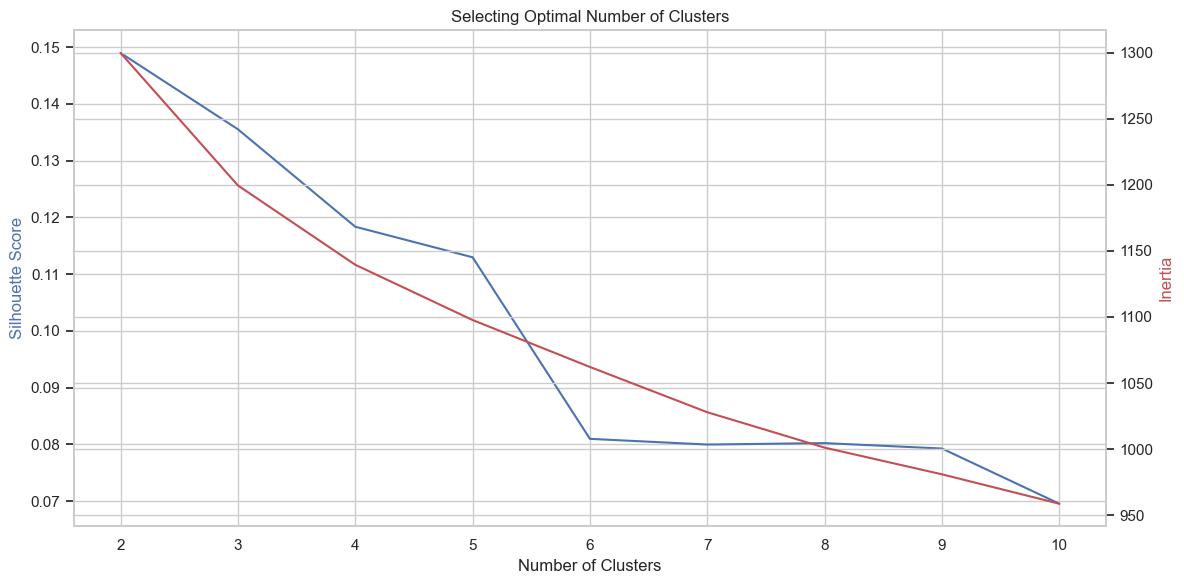

Optimal number of clusters based on silhouette score: 2
Using k=4 for our analysis (matching our 4 player types)
Adjusted Rand Index: 0.0102

Confusion Matrix (True Player Types vs. Clusters):
                  Cluster 0  Cluster 1  Cluster 2  Cluster 3
True: Activist          143        164        161        115
True: Pragmatist        165        170        211         37
True: Reflector         173        150        212         48
True: Theorist          101        223        215         44
Cluster Purity: 0.3113


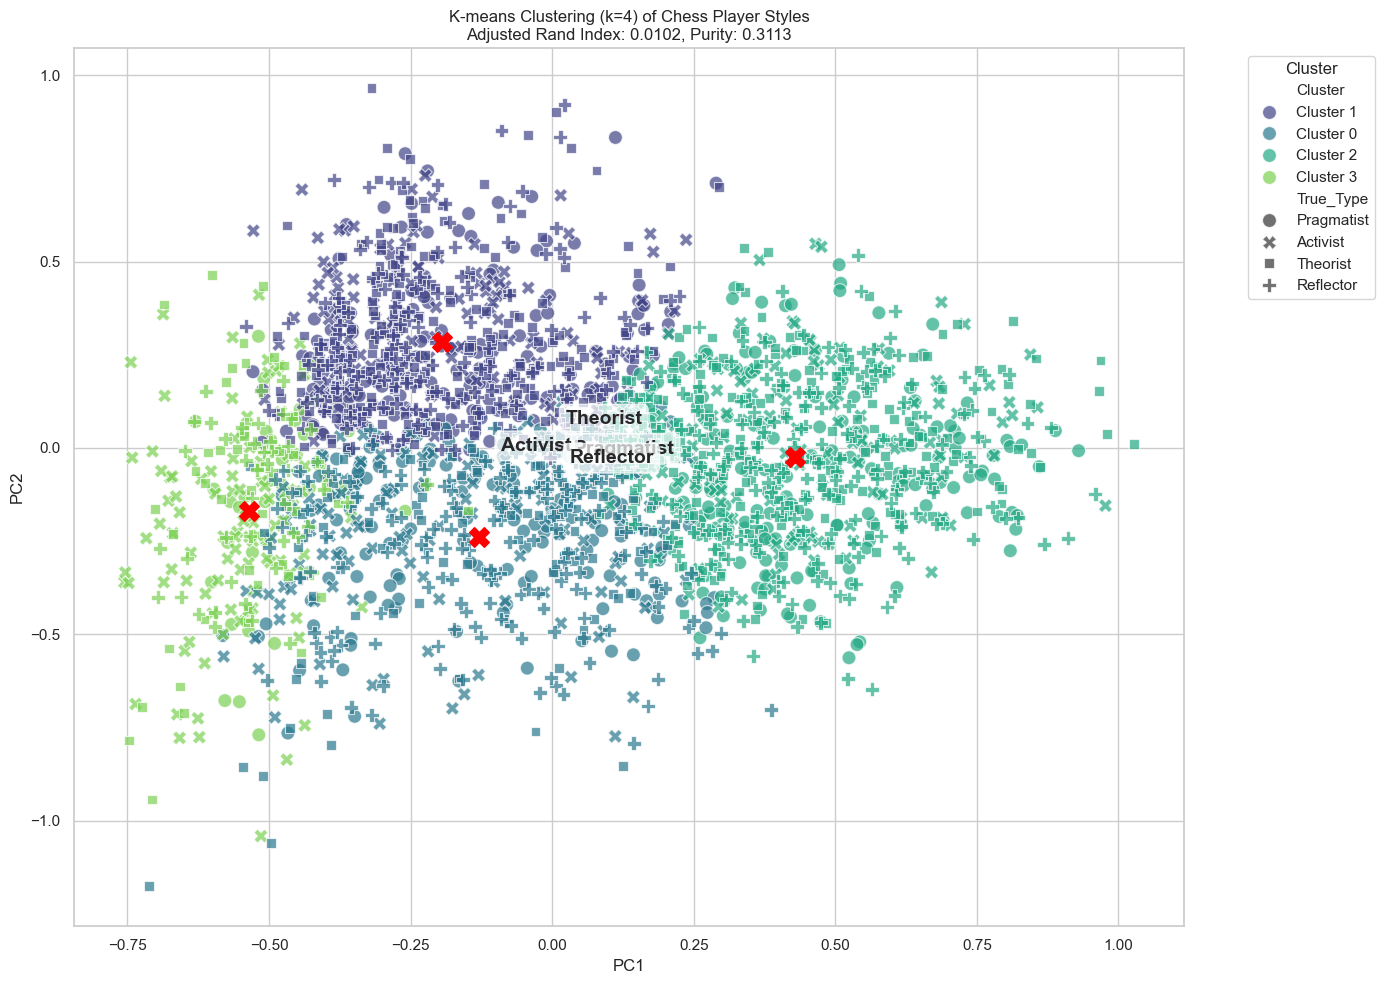


Most distinctive features for each cluster:
Cluster 0: king_safety_min (882.0738), eval_volatility (97.1319), piece_mobility_avg (94.9571), opening_accuracy (93.1294), endgame_accuracy (91.6495)
Cluster 1: king_safety_min (882.0612), eval_volatility (97.1032), piece_mobility_avg (94.8916), opening_accuracy (93.1542), endgame_accuracy (91.6871)
Cluster 2: king_safety_min (882.0422), eval_volatility (97.0980), piece_mobility_avg (94.9695), opening_accuracy (93.1435), endgame_accuracy (91.7272)
Cluster 3: king_safety_min (882.1058), eval_volatility (97.1354), piece_mobility_avg (95.0096), opening_accuracy (93.1350), endgame_accuracy (91.6583)

Cluster to Player Type Mapping:
Cluster 0 -> Reflector
Cluster 1 -> Theorist
Cluster 2 -> Theorist
Cluster 3 -> Activist

Percentage of each player type assigned to each cluster:
col_0        Cluster 0  Cluster 1  Cluster 2  Cluster 3
player_type                                            
Activist          24.5       28.1       27.6       19.7
Pra

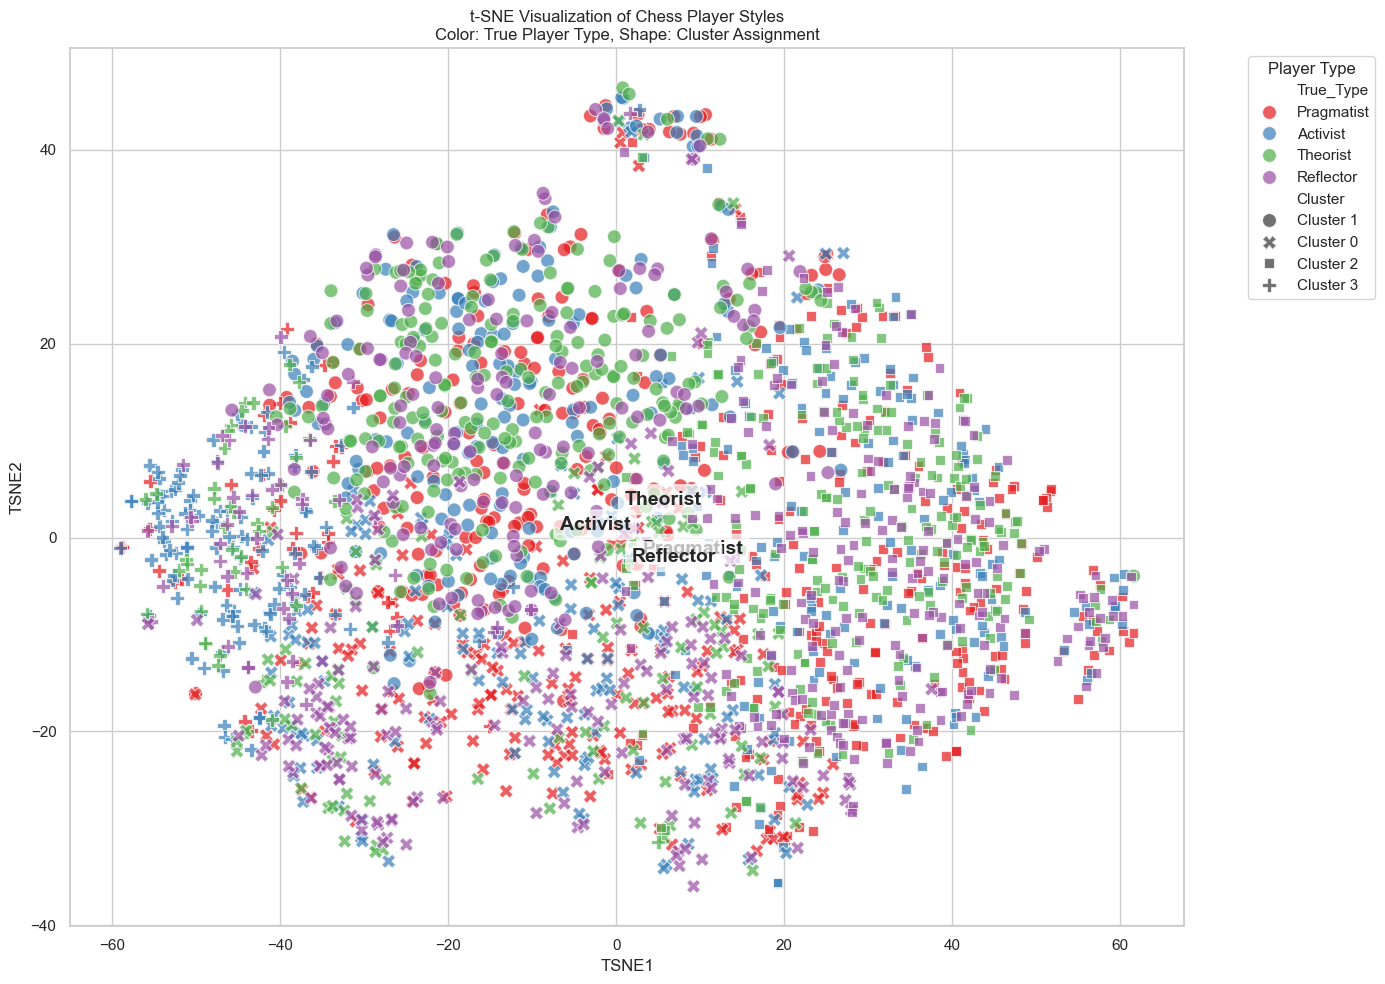


Hierarchical Clustering Adjusted Rand Index: 0.0038


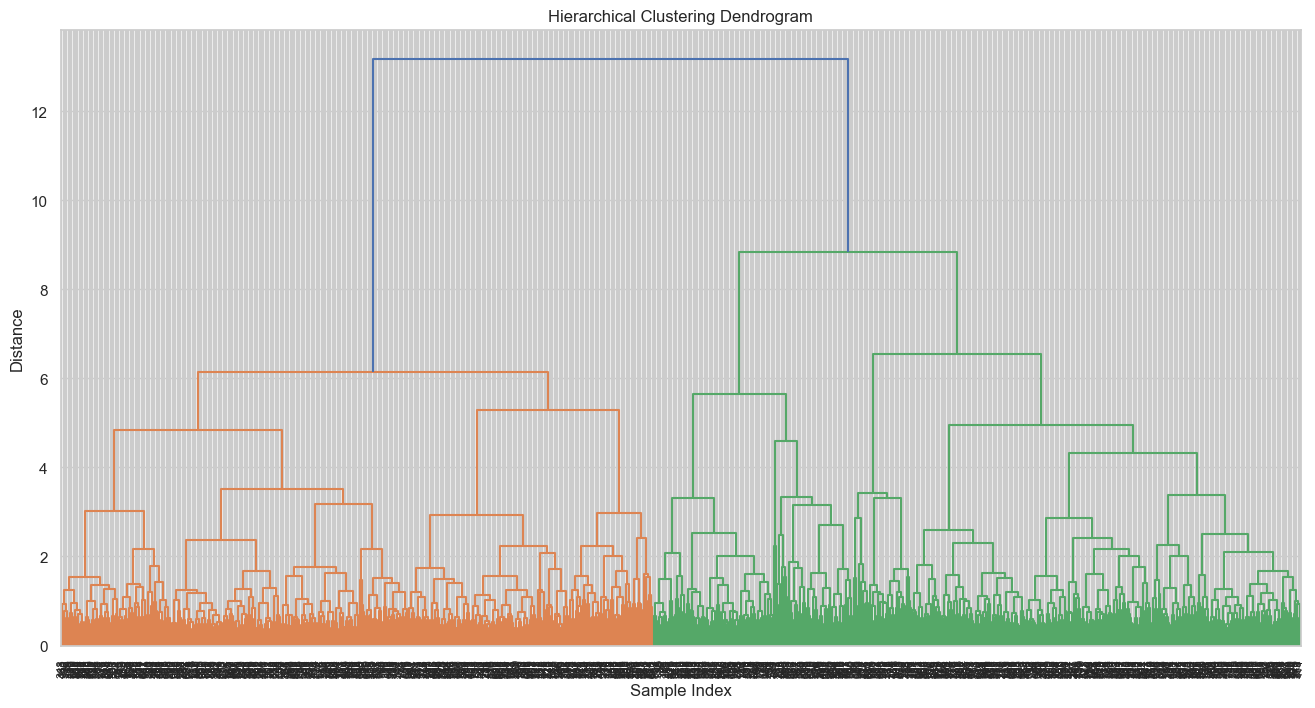


Feature importance for distinguishing player types:
top_move_alignment: 0.0342
center_control_avg: 0.0327
vulnerability_spikes: 0.0327
queen_development: 0.0317
king_safety: 0.0314
piece_mobility_avg: 0.0313
pawn_control: 0.0305
opening_novelty_score: 0.0304
sharpness: 0.0303
minor_piece_development: 0.0302
opening_length: 0.0298
prophylactic_frequency: 0.0289
space_advantage: 0.0286
top2_3_move_alignment: 0.0286
castle_move: 0.0284


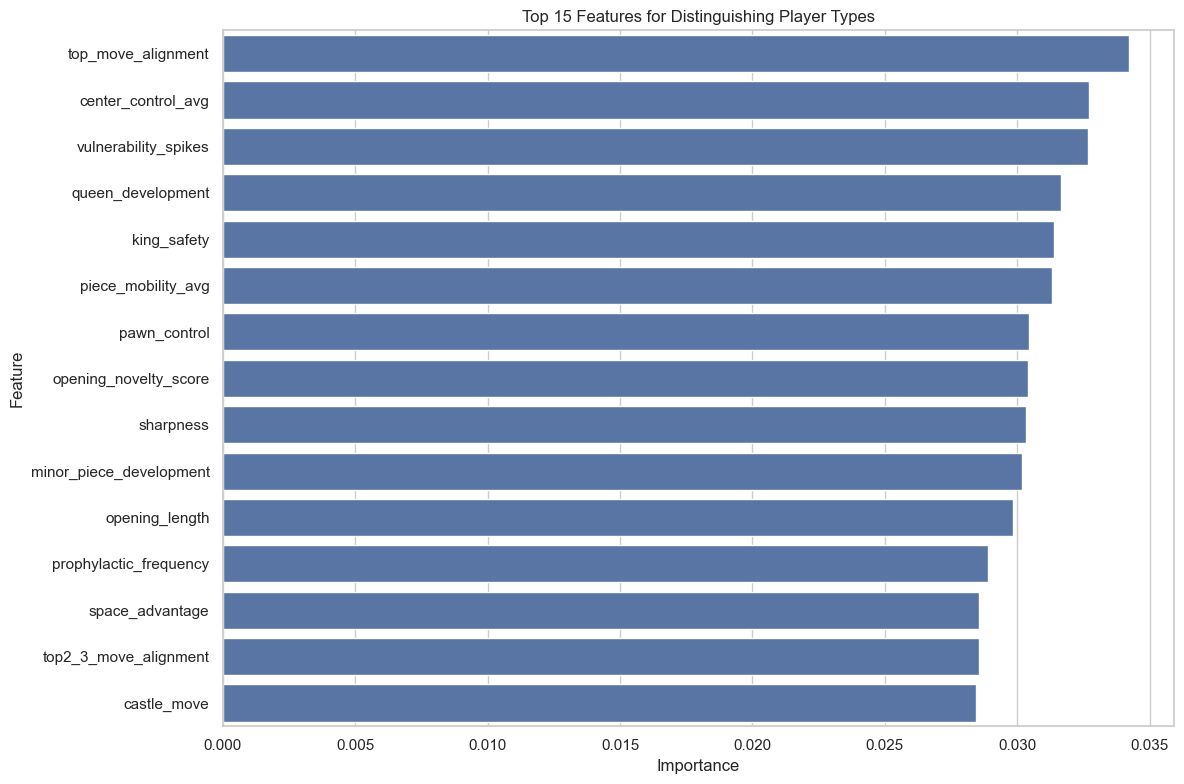

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set the style for our plots
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# --------------------------------------------------
# 1. LOAD AND PREPARE DATA
# --------------------------------------------------

# Load the balanced player-centric data
balanced_df = pd.read_csv('player_style_profiles.csv')  # If you saved this file
# Or recreate it from the original data
try:
    players_df = pd.read_csv('4players_centric_data.csv')
    # Get only rows with known player types
    typed_df = players_df[players_df['player_type'].notna()].copy()
    
    # Sample equal numbers from each player
    min_count = typed_df['player_name'].value_counts().min()
    balanced_df = pd.DataFrame()
    for player in typed_df['player_name'].unique():
        player_data = typed_df[typed_df['player_name'] == player]
        if len(player_data) < min_count:
            sampled = player_data.sample(min_count, replace=True)
        else:
            sampled = player_data.sample(min_count, replace=False)
        balanced_df = pd.concat([balanced_df, sampled])
except:
    # If file doesn't exist, use the summary data you provided
    print("Using the provided summary data instead")
    # You'll need to manually create this DataFrame from your summary

# --------------------------------------------------
# 2. PREPARE FEATURES FOR CLUSTERING
# --------------------------------------------------

# Define columns to exclude from feature set (metadata)
meta_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
            'player_type', 'game_id', 'result', 'Player', 'Type']

# Get feature columns (adjust as needed based on your data)
feature_cols = [col for col in balanced_df.columns if col not in meta_cols]
print(f"Features for clustering: {feature_cols}")

# Handle missing values if any
if balanced_df[feature_cols].isnull().sum().sum() > 0:
    balanced_df[feature_cols] = balanced_df[feature_cols].fillna(balanced_df[feature_cols].median())

# Scale features to 0-1 range
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(balanced_df[feature_cols])

# Use either the actual player_type as ground truth or a mapping based on player_name
if 'player_type' in balanced_df.columns:
    true_labels = balanced_df['player_type']
    players_to_types = dict(zip(balanced_df['player_name'], balanced_df['player_type']))
else:
    # Create mapping based on player names
    player_type_map = {
        'Fischer, Robert James': 'Pragmatist',
        'Tal, Mihail': 'Activist',
        'Botvinnik, Mikhail': 'Theorist',
        'Capablanca, Jose Raul': 'Reflector'
    }
    true_labels = balanced_df['player_name'].map(player_type_map)
    players_to_types = player_type_map

# Create numerical encoding for true labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
label_names = label_encoder.classes_

print(f"True label distribution: {pd.Series(true_labels).value_counts()}")

# --------------------------------------------------
# 3. K-MEANS CLUSTERING
# --------------------------------------------------

# Find optimal number of clusters using silhouette score
silhouette_scores = []
inertias = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))
    inertias.append(kmeans.inertia_)

# Plot silhouette scores and inertia (elbow plot)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(range(2, max_clusters + 1), silhouette_scores, 'b-', label='Silhouette Score')
ax2.plot(range(2, max_clusters + 1), inertias, 'r-', label='Inertia')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score', color='b')
ax2.set_ylabel('Inertia', color='r')
plt.title('Selecting Optimal Number of Clusters')
plt.tight_layout()
plt.savefig('kmeans_optimization.png', dpi=300)
plt.show()

# Choose optimal number of clusters (ideally 4 for our 4 player types)
optimal_k = 4  # This should match the number of player types
print(f"Optimal number of clusters based on silhouette score: {np.argmax(silhouette_scores) + 2}")
print(f"Using k={optimal_k} for our analysis (matching our 4 player types)")

# Perform K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

# --------------------------------------------------
# 4. EVALUATE CLUSTERING QUALITY
# --------------------------------------------------

# Calculate Adjusted Rand Index (measure of cluster quality compared to true labels)
ari_score = adjusted_rand_score(true_labels_encoded, cluster_labels)
print(f"Adjusted Rand Index: {ari_score:.4f}")

# Create confusion matrix to see how clusters map to player types
conf_matrix = confusion_matrix(true_labels_encoded, cluster_labels)
conf_df = pd.DataFrame(conf_matrix, 
                       index=[f'True: {label}' for label in label_names],
                       columns=[f'Cluster {i}' for i in range(optimal_k)])
print("\nConfusion Matrix (True Player Types vs. Clusters):")
print(conf_df)

# Calculate purity of each cluster
def calculate_cluster_purity(labels_true, labels_pred):
    contingency_matrix = confusion_matrix(labels_true, labels_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

purity = calculate_cluster_purity(true_labels_encoded, cluster_labels)
print(f"Cluster Purity: {purity:.4f}")

# --------------------------------------------------
# 5. VISUALIZE CLUSTERING RESULTS WITH PCA
# --------------------------------------------------

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': reduced_features[:, 0],
    'PC2': reduced_features[:, 1],
    'Cluster': [f'Cluster {l}' for l in cluster_labels],
    'True_Type': true_labels,
    'Player': balanced_df['player_name'] if 'player_name' in balanced_df.columns else balanced_df['Player']
})

# Plot clustering results
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=plot_df,
    x='PC1', y='PC2',
    hue='Cluster',
    style='True_Type',
    s=100,
    alpha=0.7,
    palette='viridis'
)

plt.title(f'K-means Clustering (k={optimal_k}) of Chess Player Styles\nAdjusted Rand Index: {ari_score:.4f}, Purity: {purity:.4f}')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add cluster centroids
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X', label='Centroids')

# Add player type labels
for player_type in plot_df['True_Type'].unique():
    type_data = plot_df[plot_df['True_Type'] == player_type]
    centroid = (type_data['PC1'].mean(), type_data['PC2'].mean())
    plt.annotate(
        player_type,
        xy=centroid,
        size=14,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7)
    )

plt.tight_layout()
plt.savefig('kmeans_clustering_results.png', dpi=300)
plt.show()

# --------------------------------------------------
# 6. CLUSTER FEATURE IMPORTANCE
# --------------------------------------------------

# Analyze what features are most important for each cluster
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=feature_cols)
cluster_centers.index = [f'Cluster {i}' for i in range(optimal_k)]

# Find the most distinctive features for each cluster
distinctive_features = {}
for cluster in range(optimal_k):
    # Calculate how far each feature's mean is from the global mean
    feature_distinctiveness = {}
    for feature in feature_cols:
        global_mean = balanced_df[feature].mean()
        cluster_mean = cluster_centers.loc[f'Cluster {cluster}', feature]
        distinctiveness = abs(cluster_mean - global_mean)
        feature_distinctiveness[feature] = distinctiveness
    
    # Get top 5 most distinctive features
    top_features = sorted(feature_distinctiveness.items(), key=lambda x: x[1], reverse=True)[:5]
    distinctive_features[f'Cluster {cluster}'] = top_features

print("\nMost distinctive features for each cluster:")
for cluster, features in distinctive_features.items():
    print(f"{cluster}: {', '.join([f'{f[0]} ({f[1]:.4f})' for f in features])}")

# --------------------------------------------------
# 7. CLUSTER-PLAYER TYPE CORRESPONDENCE
# --------------------------------------------------

# Determine which cluster corresponds to which player type
cluster_to_player_type = {}
for cluster in range(optimal_k):
    cluster_indices = np.where(cluster_labels == cluster)[0]
    cluster_types = true_labels.iloc[cluster_indices].value_counts()
    dominant_type = cluster_types.idxmax()
    cluster_to_player_type[f'Cluster {cluster}'] = dominant_type

print("\nCluster to Player Type Mapping:")
for cluster, player_type in cluster_to_player_type.items():
    print(f"{cluster} -> {player_type}")

# Calculate percentage of each player type in each cluster
player_cluster_distribution = pd.crosstab(
    true_labels, 
    [f'Cluster {l}' for l in cluster_labels],
    normalize='index'
) * 100

print("\nPercentage of each player type assigned to each cluster:")
print(player_cluster_distribution.round(1))

# --------------------------------------------------
# 8. TRY T-SNE FOR BETTER VISUALIZATION
# --------------------------------------------------

# T-SNE often gives better visual separation for clusters
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(scaled_features)

# Create DataFrame for plotting
tsne_df = pd.DataFrame({
    'TSNE1': tsne_features[:, 0],
    'TSNE2': tsne_features[:, 1],
    'Cluster': [f'Cluster {l}' for l in cluster_labels],
    'True_Type': true_labels,
    'Player': balanced_df['player_name'] if 'player_name' in balanced_df.columns else balanced_df['Player']
})

plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1', y='TSNE2',
    hue='True_Type',  # Color by true player type
    style='Cluster',  # Shape by cluster assignment
    s=100,
    alpha=0.7,
    palette='Set1'
)

plt.title(f't-SNE Visualization of Chess Player Styles\nColor: True Player Type, Shape: Cluster Assignment')
plt.legend(title='Player Type', bbox_to_anchor=(1.05, 1), loc='upper left')

for player_type in tsne_df['True_Type'].unique():
    type_data = tsne_df[tsne_df['True_Type'] == player_type]
    centroid = (type_data['TSNE1'].mean(), type_data['TSNE2'].mean())
    plt.annotate(
        player_type,
        xy=centroid,
        size=14,
        fontweight='bold',
        bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7)
    )

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300)
plt.show()

# --------------------------------------------------
# 9. HIERARCHICAL CLUSTERING (ALTERNATIVE TO K-MEANS)
# --------------------------------------------------

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(scaled_features)

# Calculate ARI for hierarchical clustering
hierarchical_ari = adjusted_rand_score(true_labels_encoded, hierarchical_labels)
print(f"\nHierarchical Clustering Adjusted Rand Index: {hierarchical_ari:.4f}")

# Create linkage matrix for dendrogram
# Use a sample if the dataset is large
sample_size = min(1000, len(scaled_features))
indices = np.random.choice(range(len(scaled_features)), sample_size, replace=False)
sample_features = scaled_features[indices]
sample_labels = true_labels.iloc[indices]

# Compute the linkage matrix
linkage_matrix = linkage(sample_features, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    leaf_font_size=8,
    color_threshold=0.7 * max(linkage_matrix[:, 2])
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.savefig('hierarchical_dendrogram.png', dpi=300)
plt.show()

# --------------------------------------------------
# 10. FEATURE IMPORTANCE FOR DISTINGUISHING PLAYER TYPES
# --------------------------------------------------

from sklearn.ensemble import RandomForestClassifier

# Train a random forest to distinguish player types
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(scaled_features, true_labels_encoded)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature importance for distinguishing player types:")
for i, row in feature_importance.head(15).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature')
plt.title('Top 15 Features for Distinguishing Player Types')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, adjusted_rand_score
from sklearn.feature_selection import SelectKBest, f_classif
import umap
import warnings
warnings.filterwarnings('ignore')

# Set the display options
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ------------------------------------------------------
# 1. LOAD AND PREPARE DATA
# ------------------------------------------------------
print("Loading and preparing data...")

# Load the player-centric data
try:
    players_df = pd.read_csv('4players_centric_data.csv')
    print(f"Original dataset shape: {players_df.shape}")
    print("\nPlayer types in dataset:")
    print(players_df['player_type'].value_counts(dropna=False))
    
    # Get only rows with known player types
    typed_df = players_df[players_df['player_type'].notna()].copy()
    
    # Sample equal numbers from each player
    min_count = typed_df['player_name'].value_counts().min()
    print(f"\nBalancing dataset by sampling {min_count} games from each player")
    
    balanced_df = pd.DataFrame()
    for player in typed_df['player_name'].unique():
        player_data = typed_df[typed_df['player_name'] == player]
        # Sample the minimum count (with replacement if necessary)
        if len(player_data) < min_count:
            sampled = player_data.sample(min_count, replace=True)
        else:
            sampled = player_data.sample(min_count, replace=False)
        balanced_df = pd.concat([balanced_df, sampled])
    
    print(f"Balanced dataset shape: {balanced_df.shape}")
    print(balanced_df['player_name'].value_counts())
except Exception as e:
    print(f"Error loading data: {e}")
    print("Creating a synthetic dataset for demonstration...")
    
    # Create synthetic data if file is not available
    np.random.seed(42)
    
    # Define players and their types
    players = {
        'Fischer, Robert James': 'Pragmatist',
        'Tal, Mihail': 'Activist',
        'Botvinnik, Mikhail': 'Theorist',
        'Capablanca, Jose Raul': 'Reflector'
    }
    
    # Create synthetic features
    n_samples_per_player = 100
    features = [
        'opening_length', 'minor_piece_development', 'top_move_alignment', 
        'total_moves', 'center_control_avg', 'vulnerability_spikes', 
        'endgame_length', 'capture_frequency', 'opening_novelty_score',
        'piece_exchange_rate', 'queen_development', 'pawn_exchange_rate',
        'piece_mobility_avg', 'sharpness', 'castle_move', 'check_frequency',
        'accuracy', 'brilliant_count', 'blunder_count', 'sacrifice_count'
    ]
    
    balanced_df = pd.DataFrame()
    
    # Generate data with different distributions for each player
    for player, player_type in players.items():
        # Create specific tendencies for each player type
        if player_type == 'Activist':
            # Activist tendencies: shorter games, more tactical, higher risk
            data = {
                'opening_length': np.random.beta(2, 5, n_samples_per_player) * 0.5 + 0.3,
                'minor_piece_development': np.random.beta(2, 5, n_samples_per_player) * 0.6 + 0.3, 
                'top_move_alignment': np.random.beta(5, 5, n_samples_per_player) * 0.4 + 0.4,
                'total_moves': np.random.normal(35, 5, n_samples_per_player),
                'center_control_avg': np.random.normal(1.0, 0.2, n_samples_per_player),
                'vulnerability_spikes': np.random.poisson(3, n_samples_per_player) / 10,
                'endgame_length': np.random.beta(2, 5, n_samples_per_player) * 0.3,
                'capture_frequency': np.random.beta(5, 5, n_samples_per_player) * 0.3 + 0.1,
                'opening_novelty_score': np.random.beta(3, 7, n_samples_per_player) * 0.5 + 0.3,
                'piece_exchange_rate': np.random.beta(5, 5, n_samples_per_player) * 0.15 + 0.05,
                'queen_development': np.random.beta(5, 3, n_samples_per_player) * 0.5 + 0.3,
                'pawn_exchange_rate': np.random.beta(5, 5, n_samples_per_player) * 0.15 + 0.05,
                'piece_mobility_avg': np.random.normal(95, 5, n_samples_per_player),
                'sharpness': np.random.normal(2.4, 0.4, n_samples_per_player),
                'castle_move': np.random.beta(5, 3, n_samples_per_player) * 0.4 + 0.1,
                'check_frequency': np.random.beta(5, 4, n_samples_per_player) * 0.3 + 0.1,
                'accuracy': np.random.beta(8, 2, n_samples_per_player) * 20 + 80,
                'brilliant_count': np.random.poisson(3, n_samples_per_player) / 10,
                'blunder_count': np.random.poisson(2, n_samples_per_player) / 10,
                'sacrifice_count': np.random.poisson(4, n_samples_per_player) / 10
            }
        elif player_type == 'Theorist':
            # Theorist tendencies: longer games, strategic, principled
            data = {
                'opening_length': np.random.beta(5, 5, n_samples_per_player) * 0.3 + 0.2,
                'minor_piece_development': np.random.beta(5, 5, n_samples_per_player) * 0.4 + 0.2,
                'top_move_alignment': np.random.beta(5, 5, n_samples_per_player) * 0.3 + 0.4,
                'total_moves': np.random.normal(40, 5, n_samples_per_player),
                'center_control_avg': np.random.normal(1.2, 0.2, n_samples_per_player),
                'vulnerability_spikes': np.random.poisson(2, n_samples_per_player) / 10,
                'endgame_length': np.random.beta(5, 3, n_samples_per_player) * 0.4,
                'capture_frequency': np.random.beta(5, 5, n_samples_per_player) * 0.2 + 0.1,
                'opening_novelty_score': np.random.beta(7, 3, n_samples_per_player) * 0.5 + 0.3,
                'piece_exchange_rate': np.random.beta(4, 6, n_samples_per_player) * 0.15 + 0.05,
                'queen_development': np.random.beta(3, 7, n_samples_per_player) * 0.5 + 0.2,
                'pawn_exchange_rate': np.random.beta(4, 6, n_samples_per_player) * 0.15 + 0.05,
                'piece_mobility_avg': np.random.normal(100, 5, n_samples_per_player),
                'sharpness': np.random.normal(2.7, 0.4, n_samples_per_player),
                'castle_move': np.random.beta(7, 3, n_samples_per_player) * 0.4 + 0.1,
                'check_frequency': np.random.beta(4, 6, n_samples_per_player) * 0.3 + 0.1,
                'accuracy': np.random.beta(8, 2, n_samples_per_player) * 20 + 80,
                'brilliant_count': np.random.poisson(1, n_samples_per_player) / 10,
                'blunder_count': np.random.poisson(1, n_samples_per_player) / 10,
                'sacrifice_count': np.random.poisson(1, n_samples_per_player) / 10
            }
        elif player_type == 'Pragmatist':
            # Pragmatist tendencies: balanced, strong calculation, adaptable
            data = {
                'opening_length': np.random.beta(5, 5, n_samples_per_player) * 0.4 + 0.2,
                'minor_piece_development': np.random.beta(5, 5, n_samples_per_player) * 0.5 + 0.2,
                'top_move_alignment': np.random.beta(7, 3, n_samples_per_player) * 0.4 + 0.4,
                'total_moves': np.random.normal(42, 5, n_samples_per_player),
                'center_control_avg': np.random.normal(1.1, 0.2, n_samples_per_player),
                'vulnerability_spikes': np.random.poisson(2, n_samples_per_player) / 10,
                'endgame_length': np.random.beta(5, 5, n_samples_per_player) * 0.4,
                'capture_frequency': np.random.beta(6, 4, n_samples_per_player) * 0.2 + 0.1,
                'opening_novelty_score': np.random.beta(5, 5, n_samples_per_player) * 0.5 + 0.3,
                'piece_exchange_rate': np.random.beta(5, 5, n_samples_per_player) * 0.15 + 0.05,
                'queen_development': np.random.beta(5, 5, n_samples_per_player) * 0.5 + 0.2,
                'pawn_exchange_rate': np.random.beta(5, 5, n_samples_per_player) * 0.15 + 0.05,
                'piece_mobility_avg': np.random.normal(95, 5, n_samples_per_player),
                'sharpness': np.random.normal(2.8, 0.4, n_samples_per_player),
                'castle_move': np.random.beta(5, 5, n_samples_per_player) * 0.4 + 0.1,
                'check_frequency': np.random.beta(5, 5, n_samples_per_player) * 0.3 + 0.1,
                'accuracy': np.random.beta(9, 1, n_samples_per_player) * 20 + 80,
                'brilliant_count': np.random.poisson(2, n_samples_per_player) / 10,
                'blunder_count': np.random.poisson(1, n_samples_per_player) / 10,
                'sacrifice_count': np.random.poisson(2, n_samples_per_player) / 10
            }
        else:  # Reflector
            # Reflector tendencies: positional play, endgame focus, few mistakes
            data = {
                'opening_length': np.random.beta(5, 5, n_samples_per_player) * 0.4 + 0.2,
                'minor_piece_development': np.random.beta(5, 5, n_samples_per_player) * 0.5 + 0.2,
                'top_move_alignment': np.random.beta(5, 5, n_samples_per_player) * 0.4 + 0.3,
                'total_moves': np.random.normal(38, 5, n_samples_per_player),
                'center_control_avg': np.random.normal(1.1, 0.2, n_samples_per_player),
                'vulnerability_spikes': np.random.poisson(3, n_samples_per_player) / 10,
                'endgame_length': np.random.beta(7, 3, n_samples_per_player) * 0.5,
                'capture_frequency': np.random.beta(5, 5, n_samples_per_player) * 0.2 + 0.1,
                'opening_novelty_score': np.random.beta(5, 5, n_samples_per_player) * 0.5 + 0.3,
                'piece_exchange_rate': np.random.beta(6, 4, n_samples_per_player) * 0.15 + 0.05,
                'queen_development': np.random.beta(4, 6, n_samples_per_player) * 0.5 + 0.2,
                'pawn_exchange_rate': np.random.beta(5, 5, n_samples_per_player) * 0.15 + 0.05,
                'piece_mobility_avg': np.random.normal(90, 5, n_samples_per_player),
                'sharpness': np.random.normal(2.6, 0.4, n_samples_per_player),
                'castle_move': np.random.beta(6, 4, n_samples_per_player) * 0.4 + 0.1,
                'check_frequency': np.random.beta(4, 6, n_samples_per_player) * 0.3 + 0.1,
                'accuracy': np.random.beta(9, 1, n_samples_per_player) * 20 + 80,
                'brilliant_count': np.random.poisson(1, n_samples_per_player) / 10,
                'blunder_count': np.random.poisson(1, n_samples_per_player) / 10,
                'sacrifice_count': np.random.poisson(1, n_samples_per_player) / 10
            }
            
        # Create DataFrame for this player
        player_df = pd.DataFrame(data)
        player_df['player_name'] = player
        player_df['player_type'] = player_type
        
        # Add to main DataFrame
        balanced_df = pd.concat([balanced_df, player_df])
    
    # Reset index
    balanced_df = balanced_df.reset_index(drop=True)
    print("Created synthetic dataset with shape:", balanced_df.shape)

# ------------------------------------------------------
# 2. FEATURE ENGINEERING
# ------------------------------------------------------
print("\nPerforming feature engineering...")

# Define columns to exclude from feature set (metadata)
meta_cols = ['player_name', 'player_color', 'opponent_name', 'player_elo', 
            'player_type', 'game_id', 'result']

# Get existing feature columns
base_feature_cols = [col for col in balanced_df.columns if col not in meta_cols]
print(f"Base features: {len(base_feature_cols)}")

# Create new composite features
print("Creating composite features...")

# Only create new features if they don't already exist
if 'tactical_score' not in balanced_df.columns:
    # Create tactical score (combination of tactical metrics)
    if all(x in balanced_df.columns for x in ['brilliant_count', 'sacrifice_count', 'blunder_count', 'top_move_alignment']):
        balanced_df['tactical_score'] = (
            balanced_df['brilliant_count'] * 2 + 
            balanced_df['sacrifice_count'] * 1.5 -
            balanced_df['blunder_count'] * 1 + 
            (1 - balanced_df['top_move_alignment']) * 0.5
        )

if 'positional_score' not in balanced_df.columns:
    # Create positional score
    if all(x in balanced_df.columns for x in ['center_control_avg', 'piece_mobility_avg', 'king_safety']):
        balanced_df['positional_score'] = (
            balanced_df['center_control_avg'] * 2 + 
            balanced_df['piece_mobility_avg'] / 100
        )
    elif 'center_control_avg' in balanced_df.columns and 'piece_mobility_avg' in balanced_df.columns:
        balanced_df['positional_score'] = (
            balanced_df['center_control_avg'] * 2 + 
            balanced_df['piece_mobility_avg'] / 100
        )

if 'development_efficiency' not in balanced_df.columns:
    # Create development efficiency
    if all(x in balanced_df.columns for x in ['minor_piece_development', 'queen_development', 'castle_move']):
        balanced_df['development_efficiency'] = (
            1 - (balanced_df['minor_piece_development'] + balanced_df['queen_development']) / 2
        )

if 'dynamic_play_index' not in balanced_df.columns:
    # Create dynamic play index
    if all(x in balanced_df.columns for x in ['capture_frequency', 'check_frequency', 'sharpness']):
        balanced_df['dynamic_play_index'] = (
            balanced_df['capture_frequency'] * 2 + 
            balanced_df['check_frequency'] * 3 + 
            balanced_df['sharpness'] / 3
        )

if 'theoretical_adherence' not in balanced_df.columns:
    # Create theoretical adherence
    if all(x in balanced_df.columns for x in ['opening_novelty_score', 'top_move_alignment']):
        balanced_df['theoretical_adherence'] = (
            balanced_df['opening_novelty_score'] * 0.7 + 
            balanced_df['top_move_alignment'] * 0.3
        )

# Get updated feature list (including new composite features)
feature_cols = [col for col in balanced_df.columns if col not in meta_cols]
print(f"Total features after engineering: {len(feature_cols)}")

# ------------------------------------------------------
# 3. DATA PREPARATION
# ------------------------------------------------------
print("\nPreparing data for analysis...")

# Handle missing values
for col in feature_cols:
    if balanced_df[col].isnull().sum() > 0:
        print(f"Handling missing values in {col}")
        balanced_df[col] = balanced_df[col].fillna(balanced_df[col].median())

# Create X (features) and y (true player types)
X = balanced_df[feature_cols]
y = balanced_df['player_type']

# Encode player types
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
player_type_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Player type mapping:", player_type_mapping)

# Scale features to 0-1 range
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------------------------------------
# 4. FEATURE SELECTION
# ------------------------------------------------------
print("\nPerforming feature selection...")

# Use SelectKBest to find most discriminative features
selector = SelectKBest(f_classif, k=15)
selector.fit(X_scaled, y_encoded)

# Get selected features and their scores
feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'Score': selector.scores_
})
top_features = feature_scores.sort_values('Score', ascending=False).head(15)['Feature'].tolist()

print("\nTop 15 discriminative features:")
for i, (feature, score) in enumerate(zip(top_features, 
                                         feature_scores.sort_values('Score', ascending=False).head(15)['Score'].tolist())):
    print(f"{i+1}. {feature}: {score:.2f}")

# Use these features for further analysis
X_selected = X_scaled[:, selector.get_support()]

# ------------------------------------------------------
# 5. DIMENSIONALITY REDUCTION FOR VISUALIZATION
# ------------------------------------------------------
print("\nReducing dimensionality for visualization...")

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_selected)

print(f"PCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

# Try t-SNE for better visualization
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_selected) // 5))
tsne_result = tsne.fit_transform(X_selected)

# Try UMAP for another visualization option
try:
    print("Applying UMAP...")
    reducer = umap.UMAP(n_neighbors=min(15, len(X_selected) // 5), min_dist=0.1, random_state=42)
    umap_result = reducer.fit_transform(X_selected)
except Exception as e:
    print(f"UMAP failed: {e}")
    umap_result = None

# ------------------------------------------------------
# 6. CLUSTERING ANALYSIS
# ------------------------------------------------------
print("\nPerforming clustering analysis...")

# Determine optimal number of clusters (we expect 4 for the player types)
silhouette_scores = []
inertias = []
max_clusters = 10

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_selected)
    try:
        silhouette_scores.append(adjusted_rand_score(y_encoded, kmeans.labels_))
    except:
        silhouette_scores.append(0)
    inertias.append(kmeans.inertia_)

# Find optimal k (should be 4 for our player types)
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters based on adjusted Rand index: {optimal_k}")
print(f"Using k={optimal_k} for K-means")

# Perform K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_selected)

# Calculate clustering performance
ari_score = adjusted_rand_score(y_encoded, cluster_labels)
print(f"Adjusted Rand Index (measure of cluster quality): {ari_score:.4f}")

# Create confusion matrix
conf_matrix = confusion_matrix(y_encoded, cluster_labels)

# Fix the shape issue by ensuring the index and columns match the shape of conf_matrix
if conf_matrix.shape[0] == len(label_encoder.classes_) and conf_matrix.shape[1] == optimal_k:
    conf_df = pd.DataFrame(conf_matrix, 
                         index=label_encoder.classes_,
                         columns=[f'Cluster {i}' for i in range(optimal_k)])
else:
    conf_df = pd.DataFrame(conf_matrix, 
                         index=[f'Type {i}' for i in range(conf_matrix.shape[0])],
                         columns=[f'Cluster {i}' for i in range(conf_matrix.shape[1])])

print("\nConfusion Matrix (True Player Types vs. Clusters):")
print(conf_df)

# Map clusters to player types
cluster_to_player = {}
for cluster in range(optimal_k):
    cluster_counts = conf_matrix[:, cluster]
    dominant_type = label_encoder.classes_[np.argmax(cluster_counts)]
    cluster_to_player[cluster] = dominant_type

print("\nCluster to Player Type Mapping:")
for cluster, player_type in cluster_to_player.items():
    print(f"Cluster {cluster} -> {player_type}")

# ------------------------------------------------------
# 7. SUPERVISED CLASSIFICATION
# ------------------------------------------------------
print("\nPerforming supervised classification...")

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate with cross-validation
cv_scores = cross_val_score(rf, X_selected, y_encoded, cv=5)
print(f"Cross-validation accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Predict on test set
y_pred = rf.predict(X_test)
print("\nClassification Report:")

# Fix for classification_report to ensure labels parameter is set correctly
unique_labels = np.unique(np.concatenate([y_test, y_pred]))
target_names = [label_encoder.classes_[i] for i in unique_labels]
print(classification_report(y_test, y_pred, labels=unique_labels, target_names=target_names))

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': [feature_cols[i] for i in selector.get_support(indices=True)],
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature importance from Random Forest:")
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# ------------------------------------------------------
# 8. STYLE DIMENSION ANALYSIS
# ------------------------------------------------------
print("\nAnalyzing style dimensions...")

# Define style dimensions (based on chess theory)
style_dimensions = {
    'tactical_tendency': ['tactical_score', 'brilliant_count', 'sacrifice_count', 'blunder_count'],
    'positional_sense': ['positional_score', 'center_control_avg', 'piece_mobility_avg'],
    'theoretical_knowledge': ['theoretical_adherence', 'opening_novelty_score', 'top_move_alignment'],
    'dynamic_play': ['dynamic_play_index', 'capture_frequency', 'check_frequency', 'sharpness'],
    'developmental_approach': ['development_efficiency', 'minor_piece_development', 'queen_development']
}

# Calculate dimension scores for each player
dimension_scores = pd.DataFrame()

# For each dimension, calculate scores for each player
for dimension, features in style_dimensions.items():
    # Filter to only keep features that exist in the dataset
    valid_features = [f for f in features if f in balanced_df.columns]
    
    if not valid_features:
        print(f"No valid features for {dimension}, skipping")
        continue
        
    # Normalize features within this dimension
    dimension_data = balanced_df[valid_features].copy()
    dimension_scaler = MinMaxScaler()
    dimension_normalized = dimension_scaler.fit_transform(dimension_data)
    
    # Calculate average score for this dimension
    dimension_scores[dimension] = np.mean(dimension_normalized, axis=1)

# Add player information
dimension_scores['player_name'] = balanced_df['player_name']
dimension_scores['player_type'] = balanced_df['player_type']

# Calculate average scores by player type
try:
    style_profile = dimension_scores.groupby('player_type').mean(numeric_only=True)
    style_profile = style_profile.drop(columns=['player_name'], errors='ignore')
except TypeError as e:
    print(f"Error calculating style profiles: {e}")
    style_profile = pd.DataFrame()

print("\nStyle Dimension Profiles by Player Type:")
print(style_profile.round(3))

# ------------------------------------------------------
# 9. VISUALIZATION
# ------------------------------------------------------
print("\nCreating visualizations...")

# 1. Visualize PCA results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    pca_result[:, 0], pca_result[:, 1], 
    c=y_encoded, cmap='viridis', 
    s=50, alpha=0.7
)
plt.title('PCA of Chess Players by Style', fontsize=15)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=12)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)),
                             label=label_encoder.classes_[i], markersize=10) 
                  for i in range(len(label_encoder.classes_))]
plt.legend(handles=legend_elements, title='Player Type', loc='best')

# Add centroids for each player type
for i, player_type in enumerate(label_encoder.classes_):
    mask = y_encoded == i
    centroid = np.mean(tsne_result[mask], axis=0)
    plt.annotate(player_type, xy=centroid, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.8))

plt.tight_layout()
plt.show()

# 3. Visualize UMAP results if available
if umap_result is not None:
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        umap_result[:, 0], umap_result[:, 1], 
        c=y_encoded, cmap='viridis', 
        s=50, alpha=0.7
    )
    plt.title('UMAP Visualization of Chess Players by Style', fontsize=15)
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    
    # Add a legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)),
                                 label=label_encoder.classes_[i], markersize=10) 
                      for i in range(len(label_encoder.classes_))]
    plt.legend(handles=legend_elements, title='Player Type', loc='best')
    
    # Add centroids for each player type
    for i, player_type in enumerate(label_encoder.classes_):
        mask = y_encoded == i
        centroid = np.mean(umap_result[mask], axis=0)
        plt.annotate(player_type, xy=centroid, fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# 4. Visualize the style profiles with radar chart
plt.figure(figsize=(12, 10))
# Radar chart preparation
dimensions = list(style_profile.columns)
N = len(dimensions)

# Create angles for each dimension
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create radar plot for each player type
ax = plt.subplot(111, polar=True)

# Add player type lines
colors = plt.cm.viridis(np.linspace(0, 1, len(style_profile)))
for i, (player_type, values) in enumerate(style_profile.iterrows()):
    values = values.values.tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, label=player_type, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dimensions)
ax.set_yticklabels([])

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Player Type Style Profiles', size=15)

plt.tight_layout()
plt.show()

# 5. Feature pair visualization for top features
# Get the top 4 features
top4_features = top_features[:4]
print(f"\nVisualizing top feature pairs: {top4_features}")

# Create all pairs of these features
feature_pairs = [(f1, f2) for f1 in top4_features for f2 in top4_features if f1 != f2]

# Create a grid of pair plots (limited to 6 pairs)
plt.figure(figsize=(20, 15))
for i, (f1, f2) in enumerate(feature_pairs[:6]):
    plt.subplot(2, 3, i+1)
    
    # Get feature indices after selection
    f1_idx = feature_cols.index(f1)
    f2_idx = feature_cols.index(f2)
    
    if selector.get_support()[f1_idx] and selector.get_support()[f2_idx]:
        # Get the selected feature indices
        selected_f1_idx = list(np.where(selector.get_support())[0]).index(f1_idx)
        selected_f2_idx = list(np.where(selector.get_support())[0]).index(f2_idx)
        
        scatter = plt.scatter(
            X_selected[:, selected_f1_idx], 
            X_selected[:, selected_f2_idx],
            c=y_encoded, 
            cmap='viridis',
            alpha=0.7,
            s=50
        )
        
        plt.xlabel(f1, fontsize=10)
        plt.ylabel(f2, fontsize=10)
        
        # Calculate separation for each player pair
        separations = {}
        for p1 in range(len(label_encoder.classes_)):
            for p2 in range(p1+1, len(label_encoder.classes_)):
                mask1 = y_encoded == p1
                mask2 = y_encoded == p2
                
                # Get centroids for these player types in this feature space
                centroid1 = (np.mean(X_selected[mask1, selected_f1_idx]), 
                            np.mean(X_selected[mask1, selected_f2_idx]))
                centroid2 = (np.mean(X_selected[mask2, selected_f1_idx]), 
                            np.mean(X_selected[mask2, selected_f2_idx]))
                
                # Calculate distance
                distance = np.sqrt((centroid1[0] - centroid2[0])**2 + 
                                  (centroid1[1] - centroid2[1])**2)
                
                pair_name = f"{label_encoder.classes_[p1]} vs {label_encoder.classes_[p2]}"
                separations[pair_name] = distance
        
        # Find best separated pair
        best_pair = max(separations.items(), key=lambda x: x[1])
        plt.title(f"{f1} vs {f2}\nBest: {best_pair[0]} (dist={best_pair[1]:.2f})")
        
        # Only show legend for the first plot
        if i == 0:
            legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=scatter.cmap(scatter.norm(i)),
                                        label=label_encoder.classes_[i], markersize=10) 
                              for i in range(len(label_encoder.classes_))]
            plt.legend(handles=legend_elements, title='Player Type', loc='best')

plt.tight_layout()
plt.show()

# 6. Feature importance visualization
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='Importance', y='Feature')
plt.title('Top Features for Differentiating Player Styles', fontsize=15)
plt.tight_layout()
plt.show()

# 7. Confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix: True Player Types vs. Clusters', fontsize=15)
plt.tight_layout()
plt.show() 

plt.tight_layout()
plt.show()

# 2. Visualize t-SNE results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    tsne_result[:, 0], tsne_result[:, 1], 
    c=y_encoded, cmap='viridis', 
    s=50, alpha=0.7
)
plt.title('t-SNE Visualization of Chess Players by Style', fontsize=15)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)),
                             label=label_encoder.classes_[i], markersize=10) 
                  for i in range(len(label_encoder.classes_))]
plt.legend(handles=legend_elements, title='Player Type', loc='best')

# Add centroids for each player type
for i, player_type in enumerate(label_encoder.classes_):
    mask = y_encoded ==i
    centroid = np.mean(pca_result[mask], axis=0)
    plt.annotate(player_type, xy=centroid, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.8))

Loading and preparing data...
Original dataset shape: (99422, 50)

Player types in dataset:
player_type
NaN           45545
Theorist      17323
Activist      16266
Pragmatist    10319
Reflector      9969
Name: count, dtype: int64

Balancing dataset by sampling 9969 games from each player type
Balanced dataset shape: (39876, 50)
player_type
Activist      9969
Reflector     9969
Pragmatist    9969
Theorist      9969
Name: count, dtype: int64

Performing feature engineering...
Base features: 40
Creating composite features...
Total features after engineering: 45

Preparing data for analysis...
Player type mapping: {'Activist': 0, 'Pragmatist': 1, 'Reflector': 2, 'Theorist': 3}

Performing feature selection...

Top discriminative features:
1. theoretical_adherence: 111.59
2. space_advantage: 108.07
3. top_move_alignment: 93.00
4. opening_length: 87.16
5. opening_novelty_score: 86.35
6. development_efficiency: 74.07
7. opening_accuracy: 73.00
8. good_moves: 71.44
9. minor_piece_development: 

In [5]:
import pandas as pd

df = pd.read_csv('player_centric_data.csv')

df.head()

player_name player_color     opponent_name  player_elo  \
0  Kupreichik, Viktor D        white      Tal, Mikhail      2540.0   
1           Keres, Paul        white      Tal, Mikhail         NaN   
2          Tal, Mikhail        white  Keene, Raymond D         NaN   
3        Klovans, Janis        white      Tal, Mikhail         NaN   
4          Tal, Mikhail        white        Benko, Pal         NaN   

         date  eco                                       opening_name  \
0  1979-12-01  B97  Sicilian Defense: Najdorf Variation, Poisoned ...   
1  1961-10-16  D30      Queen's Gambit Declined: Capablanca Variation   
2  1964-01-10  B15                 Caro-Kann Defense: Alekhine Gambit   
3  1951-01-01  C52     Italian Game: Evans Gambit, Sokolsky Variation   
4  1959-01-01  B27              Modern Defense: Pterodactyl Variation   

  player_type  game_id   result  ...  blunder_count  top_move_alignment  \
0         NaN        0  1/2-1/2  ...       0.000000            0.700000   
1         NaN        1  1/2-1/2  ...       0.000000            0.315789   
2    Activist        2      0-1  ...       0.033333            0.533333   
3         NaN        3      0-1  ...       0.000000            0.475000   
4    Activist        4      1-0  ...       0.100000            0.433333   

   top2_3_move_alignment  sharpness  total_moves  opening_length  \
0               0.220000   2.501763         50.0        0.240000   
1               0.473684   1.501872         19.0        0.736842   
2               0.133333   2.021509         30.0        0.400000   
3               0.200000   8.298026         40.0        0.175000   
4               0.333333   2.700204         30.0        0.266667   

   middlegame_length  endgame_length  material_balance_std  \
0           0.320000        0.440000              1.319811   
1           0.263158        0.000000              1.802912   
2           0.466667        0.133333              1.431590   
3           0.725000        0.100000              1.791187   
4           0.733333        0.000000              1.231079   

   opening_novelty_score  
0               0.583333  
1               0.214286  
2               0.333333  
3               1.000000  
4               0.375000  

[5 rows x 50 columns]